In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
from time import time
import seaborn as sns
import pickle
import joblib
import re
path = r"C:\Users\danie\Desktop\master_project-env\datasets_combined\Downsampled"

In [143]:
#binance
binance_book = pd.read_parquet(path + '\\binance-futures_book_snapshot_5_downsampled.parquet.gz')
binance_derivative = pd.read_parquet(path + '\\binance-futures_derivative_ticker_downsampled.parquet.gz')
binance_liquidations = pd.read_parquet(path + '\\binance-futures_liquidations_downsampled.parquet.gz')
binance_trade = pd.read_parquet(path + '\\binance-futures_trades_downsampled.parquet.gz')

#ftx
ftx_book = pd.read_parquet(path + '\\ftx_book_snapshot_5_downsampled.parquet.gz')
ftx_derivative = pd.read_parquet(path + '\\ftx_derivative_ticker_downsampled.parquet.gz')
ftx_liquidations = pd.read_parquet(path + '\\ftx_liquidations_downsampled.parquet.gz')
ftx_trade = pd.read_parquet(path + '\\ftx_trades_downsampled.parquet.gz')

# Feature Engineering

In [211]:
def decay_factor(alpha):
    exp_decay = [np.exp(alpha * i) for i in range(5)]
    return exp_decay/sum(exp_decay)

def expMid(book, alpha):
    data = pd.DataFrame()
    for level in range(5):
        VolweightedMP = (book['asks[{}].price'.format(level)]*book['bids[{}].amount'.format(level)] + book['asks[{}].amount'.format(level)]*book['bids[{}].price'.format(level)])/(
                                book['asks[{}].amount'.format(level)] + book['bids[{}].amount'.format(level)])
        data = pd.concat([data, VolweightedMP], axis=1)

    data['expMid'] = np.sum(data.values*decay_factor(0.5), axis=1)
    data.drop(columns=0, inplace=True)
    return data

def BinanceFeatures(binance_book, binance_liquidations, label):
    model = pd.DataFrame()
    
    ### mid price and target calc.
    # 'log_returns(mid_price)'
    if label == 'log_returns(mid_price)':
        mid_price_binance = (binance_book['asks[0].price'] + binance_book['bids[0].price'])/2
        model['mid_price_binance'] = mid_price_binance
        model['log_returns(mid_price)_binance'] = np.log1p(mid_price_binance.pct_change())
    #'log_returns(mid_price)_EWM5'
    
    elif label == 'log_returns(mid_price)_EWM5':
        expMidPrice_binance = expMid(binance_book, alpha=0.5)
        model['expMidPrice_binance'] = expMidPrice_binance
        model['log_returns(mid_price)_EWM5_binance'] = np.log1p(expMidPrice_binance.pct_change())
        
    #'log_returns(volWeighted_mid_price)'
    elif label == 'log_returns(volWeighted_mid_price)':
        volWeighted_midPrice_binance = (binance_book['asks[0].price']*binance_book['bids[0].amount'] + binance_book['asks[0].amount']*binance_book['bids[0].price'])/(
                                binance_book['asks[0].amount'] + binance_book['bids[0].amount'])
        
        model['volWeighted_midPrice_binance'] = volWeighted_midPrice_binance
        model['log_returns(volWeighted_mid_price)_binance'] = np.log1p(volWeighted_midPrice_binance.pct_change())
    else:
        print('Incorrect label!')
    
    ### liquidatiuon features
    model['liquidation_size_binance'] = binance_liquidations['price'] * binance_liquidations['amount']
    model.replace([np.inf, -np.inf], np.nan, inplace=True) #replace inf in liquidation col
    
    return model

def rolling_average(feature, period):
    return feature.rolling(window=period).mean()

def realised_volatility(returns, period):
    return np.sqrt(np.square(returns).rolling(period).sum())

def features(ftx_book, ftx_derivative, ftx_trade, ftx_liquidations, label):
    model = pd.DataFrame()
    
    ### mid price and target calc.
    if label == 'log_returns(mid_price)':
        mid_price = (ftx_book['asks[0].price'] + ftx_book['bids[0].price'])/2        
        model['mid_price'] = mid_price
        model['log_returns(mid_price)'] = np.log1p(mid_price.pct_change())
        model['class'] = (model['log_returns(mid_price)'] != 0).astype(int)
    elif label == 'log_returns(mid_price)_EWM5':
        expMidPrice_ftx = expMid(ftx_book, alpha=0.5)
        model['expMidPrice_ftx'] = expMidPrice_ftx
        
        model['log_returns(mid_price)_EWM5'] = np.log1p(expMidPrice_ftx.pct_change())

    elif label == 'log_returns(volWeighted_mid_price)':
        volWeighted_midPrice = (ftx_book['asks[0].price']*ftx_book['bids[0].amount'] + ftx_book['asks[0].amount']*ftx_book['bids[0].price'])/(
                                ftx_book['asks[0].amount'] + ftx_book['bids[0].amount'])
        
        model['volWeighted_midPrice'] = volWeighted_midPrice
        model['log_returns(volWeighted_mid_price)'] = np.log1p(volWeighted_midPrice.pct_change())
    else:
        print('Incorrect label!')
    
    ### moving average of y
    periods = [20, 50, 100]
    for period in periods:
        model[label + '_'+ str(period)] = rolling_average(model[label], period)

    
    ### Price features
    for level in range(5):
        model['price_spread_ratio[{}]'.format(level)] =  ftx_book['asks[{}].price'.format(level)] / ftx_book['bids[{}].price'.format(level)]
        model['price_difference[{}]'.format(level)] = ftx_book['asks[{}].price'.format(level)] - ftx_book['bids[{}].price'.format(level)] 

    model['average_price_ask'] = ftx_book.filter(like='price').filter(like='ask').mean(axis=1)
    model['average_price_bid'] = ftx_book.filter(like='price').filter(like='bid').mean(axis=1)

    #### volume features
    for level in range(5):
        model['Vol_spread_ratio[{}]'.format(level)] =  ftx_book['asks[{}].amount'.format(level)] / ftx_book['bids[{}].amount'.format(level)]
        model['vol_imbalance[{}]'.format(level)] = (ftx_book['bids[{}].amount'.format(level)] - ftx_book['asks[{}].amount'.format(level)])/(ftx_book['bids[{}].amount'.format(level)] + ftx_book['asks[{}].amount'.format(level)])
        model['vol_difference[{}]'.format(level)] = ftx_book['asks[{}].amount'.format(level)] - ftx_book['bids[{}].amount'.format(level)] 

    model['accumulated_vol_difference'] = model.filter(like='vol_difference').sum(axis=1)
    model['average_vol_ask'] = ftx_book.filter(like='amount').filter(like='ask').mean(axis=1)
    model['average_vol_bid'] = ftx_book.filter(like='amount').filter(like='bid').mean(axis=1)
    
    #discard useless columns
    for level in range(5):
        model.drop(columns=['vol_difference[{}]'.format(level)])
        model.drop(columns=['price_difference[{}]'.format(level)])

    # realised volatility - 10s
    model['realised_volatility'] = realised_volatility(model[label], 10)

    #Derivative Features
    model = model.join(ftx_derivative)
    model['fundingRate_OI_ratio'] = model['funding_rate']/model['open_interest']
    model = model.drop(columns=['funding_timestamp', 'last_price', 'last_price', 'index_price', 'mark_price'])

    #Trade Features
    model = model.join(ftx_trade)
    model = model.rename({'order_count':'total_count', 'trade_size':'average_trade_size'}, axis=1)
    model['total_average_trade_size'] = model['total_count'] * model['average_trade_size']
    model = model.drop(columns=['total_count', 'average_trade_size'])

    #cumulative features
    model['liquidation_size'] = ftx_liquidations['price'] * ftx_liquidations['amount']
    
    #datetime features by hour 
    model['hour'] = pd.to_datetime(model.index).hour

    #Previous time series features
    shift = pd.concat([model[label].shift(1), 
                            model[label].shift(2), 
                            model[label].shift(3)], axis=1)
    shift.columns = ['t-1', 't-2', 't-3'] # #rename columns
    model = pd.concat([model,shift], axis=1)
    
    #Binance features
    binance_model = BinanceFeatures(binance_book, binance_liquidations, label)
    model = pd.concat([model, binance_model], axis=1)
    
    ''' 
    Predicting t+1 so shfit all features forward by 1
    log_returns(mid_price) and class
    
    '''
    if label == 'log_returns(mid_price)':
        model = pd.concat([model.iloc[:, :2],model.iloc[:,2:].shift(1)], axis=1)
    else:
        model = pd.concat([model.iloc[:, :1],model.iloc[:,1:].shift(1)], axis=1)
     
    #drop nans
    dataset = model.dropna()
    
    #reduced the data to one week
    dataset = dataset[int(dataset.shape[0]*0.75):]
    dataset.to_parquet(r"C:\Users\danie\Desktop\master_project-env\Studies\dataset_" + label + ".pq", compression='gzip')
    
    return dataset

In [212]:
# log_returns(mid_price)_EWM5
# 'log_returns(volWeighted_mid_price)'
dataset = features(ftx_book, ftx_derivative, ftx_trade, ftx_liquidations, label='log_returns(mid_price)')
dataset.head()

invalid value encountered in sqrt


,mid_price,log_returns(mid_price),class,log_returns(mid_price)_20,log_returns(mid_price)_50,log_returns(mid_price)_100,price_spread_ratio[0],price_difference[0],price_spread_ratio[1],price_difference[1],...,fundingRate_OI_ratio,total_average_trade_size,liquidation_size,hour,t-1,t-2,t-3,mid_price_binance,log_returns(mid_price)_binance,liquidation_size_binance
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-11 07:46:03,48105.777778,-0.000015,0.0,-0.000020,0.000009,0.000014,1.000021,1.000000,1.000125,6.000000,...,3.630947e-10,1.048733e+03,0.0,7.0,0.000000,-0.000002,-0.000080,48060.000000,0.000000,0.0
2021-12-11 07:46:04,48107.447368,0.000035,1.0,-0.000020,0.000010,0.000013,1.000022,1.037037,1.000110,5.296296,...,3.630947e-10,3.884560e+05,0.0,7.0,0.000000,0.000000,-0.000002,48060.000000,0.000000,0.0
2021-12-11 07:46:05,48118.740741,0.000235,1.0,-0.000017,0.000010,0.000016,1.000036,1.736842,1.000130,6.263158,...,3.630947e-10,7.357959e+06,0.0,7.0,-0.000015,0.000000,0.000000,48060.000000,0.000000,0.0
2021-12-11 07:46:06,48120.500000,0.000037,1.0,-0.000007,0.000014,0.000018,1.000032,1.555556,1.000122,5.888889,...,3.630947e-10,5.133265e+05,0.0,7.0,0.000035,-0.000015,0.000000,48088.965517,0.000603,0.0
2021-12-11 07:46:07,48120.500000,0.000000,1.0,-0.000006,0.000010,0.000019,1.000021,1.000000,1.000132,6.363636,...,3.630947e-10,1.049038e+03,0.0,7.0,0.000235,0.000035,-0.000015,48100.000000,0.000229,0.0


In [269]:
dataset.columns

Index(['mid_price', 'log_returns(mid_price)', 'class',
       'log_returns(mid_price)_20', 'log_returns(mid_price)_50',
       'log_returns(mid_price)_100', 'price_spread_ratio[0]',
       'price_difference[0]', 'price_spread_ratio[1]', 'price_difference[1]',
       'price_spread_ratio[2]', 'price_difference[2]', 'price_spread_ratio[3]',
       'price_difference[3]', 'price_spread_ratio[4]', 'price_difference[4]',
       'average_price_ask', 'average_price_bid', 'Vol_spread_ratio[0]',
       'vol_imbalance[0]', 'vol_difference[0]', 'Vol_spread_ratio[1]',
       'vol_imbalance[1]', 'vol_difference[1]', 'Vol_spread_ratio[2]',
       'vol_imbalance[2]', 'vol_difference[2]', 'Vol_spread_ratio[3]',
       'vol_imbalance[3]', 'vol_difference[3]', 'Vol_spread_ratio[4]',
       'vol_imbalance[4]', 'vol_difference[4]', 'accumulated_vol_difference',
       'average_vol_ask', 'average_vol_bid', 'realised_volatility',
       'funding_rate', 'open_interest', 'fundingRate_OI_ratio',
       'total_av

## Automated Feature Enginnering

# Testing

In [146]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (cross_val_score,
                                     cross_validate,
                                     cross_val_predict, 
                                     GridSearchCV,
                                     TimeSeriesSplit
                                    )
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix,
                             mean_squared_error,                         
                             r2_score,
                             roc_auc_score,
                            accuracy_score,
                            make_scorer,
                            mean_absolute_error,
                            roc_curve)
from probatus.feature_elimination import ShapRFECV, EarlyStoppingShapRFECV
from sklearn.feature_selection import RFE, RFECV
import lightgbm as lgb

## Training, Validation and Test Dataset Preparation

In [147]:
def train_test_split(dataset, train_split):    
    start_train_ind = int(dataset.shape[0] * train_split)
    train_ds = dataset[:start_train_ind]
    test_ds = dataset[start_train_ind:]
    return train_ds, test_ds

## Modelling Part 1: Hurdle Model logistic Part

- Hurdle model only applicable to log_returns(mid_price) since other two targets don't have the inflated 0 issue

- Variance filter to reduce number of features

In [148]:
dataset_class = dataset.drop(columns='log_returns(mid_price)')

def corrFilter(dataset, threshold=0.01,y='class'):
    '''
     data: dataframe
     threshold: minimum correlation to y label 
    '''
    class_corr = abs(dataset.corr()[y]).sort_values(ascending=False)
    colsDrop = class_corr[(class_corr<threshold)==True].axes[0].tolist()
    dataset = dataset.drop(columns=colsDrop)
    return dataset

dataset_class = corrFilter(dataset_class)
dataset_class.shape

(597685, 37)

In [149]:
train_ds_class, test_ds_class = train_test_split(dataset_class, train_split=0.8)

y = 4 #number of predict labels
#Used for training and cross validation
X_train_class = train_ds_class.iloc[:, y:]
y_train_class = train_ds_class['class']

#Final Evaluation of selected model
X_test_class = test_ds_class.iloc[:, y:]
y_test_class = test_ds_class['class']

### Logistic Regression

- Cross validation assessment to see optimal split
- No significant difference between the splits so used 5 for further tests)

In [284]:
# %%time
# n_splits = [3, 5, 10]
# for split in n_splits:
#     tscv = TimeSeriesSplit(n_splits = split)
#     scores = cross_val_score(
#         estimator = LogisticRegression(),
#         X = X_train,
#         y = y_train,
#         cv = tscv,
#         scoring = 'accuracy'
#     )
#     print('Model accuracy: {:.4f}% ({:.4f})'.format(np.mean(scores), np.std(scores)))

- check which features were selected in RFECV
- https://stackoverflow.com/questions/35876508/evaluate-multiple-scores-on-sklearn-cross-val-score

In [313]:
sorted(np.logspace(-1, 1, 4))

[0.1, 0.46415888336127786, 2.1544346900318834, 10.0]

In [268]:
class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

#logistic Regression
def class_log(X_train, y_train, score):
    model = LogisticRegression(max_iter=2000, tol=0.01, n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits = 5)
    pipeline  = MyPipeline([('scaler', MinMaxScaler()),
                          ('model', model)])

    #RFECV
    clf_log = RFECV(estimator=pipeline, step=1, min_features_to_select=15, cv=tscv, scoring=score)
    clf_log.fit(X_train, y_train)

    #reduced feature set
    reduced_X_train = X_train.iloc[:,clf_log.support_]

    #parameter tuning
    param_grid = {"model__C": sorted(np.logspace(-1, 1, 4))}
    search_log = GridSearchCV(pipeline,
                          param_grid=param_grid,
                          scoring=score,
                          cv=tscv,
                          return_train_score=True,
                          verbose=2)

    search_log.fit(reduced_X_train, y_train)
    filename = 'logisticReg_' + score + '.sav'
    joblib.dump(search_log, filename)
    

In [270]:
%%time
class_log(X_train = X_train_class, 
          y_train = y_train_class, 
          score='roc_auc')

# class_log(X_train = X_train_class, 
#           y_train = y_train_class, 
#           score='accuracy')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................................model__C=0.1; total time=   1.0s
[CV] END .......................................model__C=0.1; total time=   1.3s
[CV] END .......................................model__C=0.1; total time=   2.4s
[CV] END .......................................model__C=0.1; total time=   3.2s
[CV] END .......................................model__C=0.1; total time=   3.3s
[CV] END .......................model__C=0.46415888336127786; total time=   1.0s
[CV] END .......................model__C=0.46415888336127786; total time=   1.9s
[CV] END .......................model__C=0.46415888336127786; total time=   3.3s
[CV] END .......................model__C=0.46415888336127786; total time=   4.1s
[CV] END .......................model__C=0.46415888336127786; total time=   3.4s
[CV] END ........................model__C=2.1544346900318834; total time=   1.8s
[CV] END ........................model__C=2.15443

In [272]:
filename = "logisticReg_accuracy.sav"
search_log_acc = joblib.load(filename)

In [273]:
filename = "logisticReg_roc_auc.sav"
search_log_roc = joblib.load(filename)

In [282]:
def log_results(search_log):
    #predicted
    reduced_X_train = X_train_class[search_log.feature_names_in_]
    reduced_X_test =  X_test_class[search_log.feature_names_in_]
    if (search_log == search_log_roc):
        predicted_proba = search_log.predict_proba(reduced_X_test)
        fpr1, tpr1, thresh1 = roc_curve(y_test_class, predicted_proba[:,1], pos_label=1)
        random_probs = [0 for i in range(len(y_test_class))]
        p_fpr, p_tpr, _ = roc_curve(y_test_class, random_probs, pos_label=1)

        plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
        plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

        # title
        plt.title('ROC curve')
        # x label
        plt.xlabel('False Positive Rate')
        # y label
        plt.ylabel('True Positive rate')

        plt.legend(loc='best')
        plt.savefig('ROC',dpi=300)
        plt.show();
    

    #compute accuracy
    train_predicted = search_log.predict(reduced_X_train)
    predicted = search_log.predict(reduced_X_test)
    
    acc_train = accuracy_score(y_train_class, train_predicted)
    print("train accuracy: {:.4f}%".format(acc_train))
    acc = accuracy_score(y_test_class, predicted)
    print("test accuracy: {:.4f}%".format(acc))
    print("C: {}".format(search_log.feature_names_in_))
    print("Optimum number of features: %d" % len(search_log.feature_names_in_))

    #coefficients
    feature_names = search_log.feature_names_in_
    feature_coefs = search_log.best_estimator_.coef_.flatten()
    features = pd.DataFrame(zip(feature_names, feature_coefs), columns=['feature', 'coefficient'])
    features['abs_coef'] = abs(feature_coefs)
    features["colors"] = features["coefficient"].apply(lambda x: "green" if x > 0 else "red")
    features = features.sort_values("abs_coef", ascending=False)
    print(features)

    #plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    sns.barplot(x="feature",
                y="coefficient",
                data=features,
               palette=features["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    if (search_log == search_log_roc):
        ax.set_title("Features Selected - Logistic Regression (AUC ROC)", fontsize=16)
    else:
          ax.set_title("Features Selected - Logistic Regression (Accuracy)", fontsize=16)
    ax.set_ylabel("Coefficient", fontsize=16)
    ax.set_xlabel("Feature Name", fontsize=16)

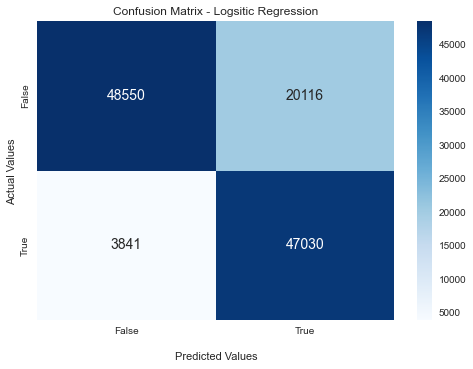

In [411]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

reduced_X_test =  X_test_class[search_log.feature_names_in_]

cf_matrix = confusion_matrix(search_log.predict(reduced_X_test), y_test_class)  
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})

ax.set_title('Confusion Matrix - Logsitic Regression');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

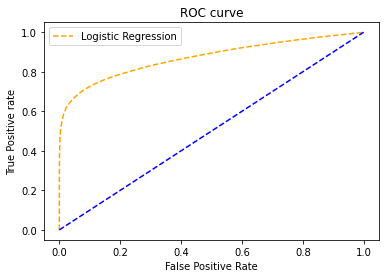

train accuracy: 0.8059%
test accuracy: 0.7996%
C: ['price_difference[1]' 'price_difference[2]' 'price_spread_ratio[3]'
 'price_difference[3]' 'price_spread_ratio[4]' 'price_difference[4]'
 'vol_difference[0]' 'Vol_spread_ratio[1]' 'vol_difference[1]'
 'Vol_spread_ratio[2]' 'vol_difference[2]' 'vol_difference[3]'
 'Vol_spread_ratio[4]' 'accumulated_vol_difference' 'realised_volatility'
 'liquidation_size_binance']
Optimum number of features: 16
                       feature  coefficient    abs_coef colors
6            vol_difference[0]   550.848446  550.848446  green
13  accumulated_vol_difference    61.254464   61.254464  green
4        price_spread_ratio[4]    27.356989   27.356989  green
2        price_spread_ratio[3]    21.395398   21.395398  green
3          price_difference[3]   -21.155740   21.155740    red
11           vol_difference[3]   -21.155740   21.155740    red
5          price_difference[4]   -18.265349   18.265349    red
15    liquidation_size_binance    15.498841   15

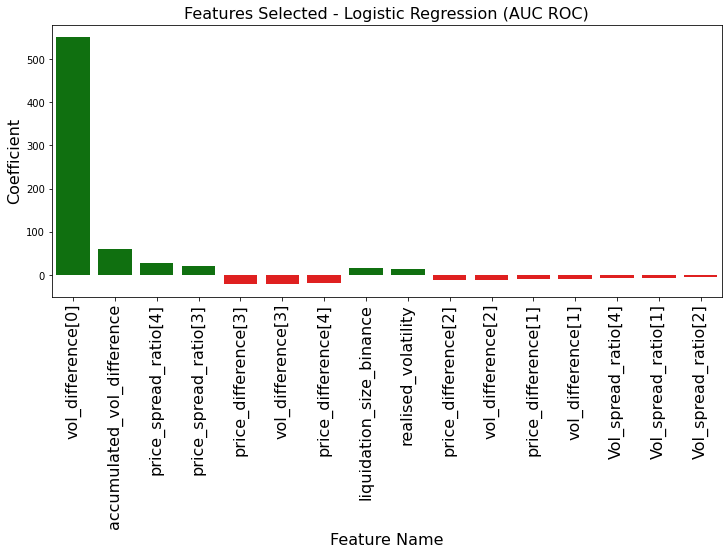

In [283]:
log_results(search_log_roc)

train accuracy: 0.8060%
test accuracy: 0.7996%
C: ['price_difference[1]' 'price_difference[2]' 'price_spread_ratio[3]'
 'price_difference[3]' 'price_spread_ratio[4]' 'price_difference[4]'
 'vol_difference[0]' 'Vol_spread_ratio[1]' 'vol_difference[1]'
 'Vol_spread_ratio[2]' 'vol_difference[2]' 'vol_difference[3]'
 'accumulated_vol_difference' 'realised_volatility'
 'liquidation_size_binance']
Optimum number of features: 15
                       feature  coefficient    abs_coef colors
6            vol_difference[0]   553.987509  553.987509  green
12  accumulated_vol_difference    61.752012   61.752012  green
4        price_spread_ratio[4]    27.101579   27.101579  green
3          price_difference[3]   -21.070709   21.070709    red
11           vol_difference[3]   -21.070709   21.070709    red
2        price_spread_ratio[3]    21.002417   21.002417  green
5          price_difference[4]   -17.996702   17.996702    red
14    liquidation_size_binance    15.527803   15.527803  green
13     

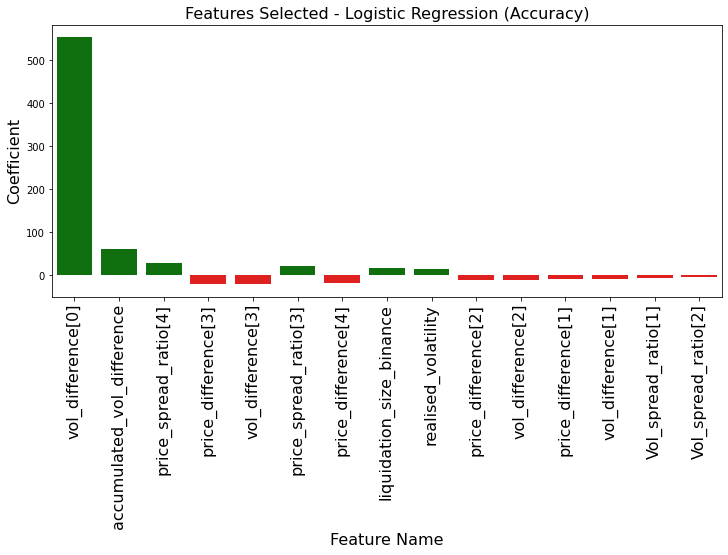

In [284]:
log_results(search_log_acc)

- Add boxplot to show performance (https://machinelearningmastery.com/rfe-feature-selection-in-python/)


### Random Forest


- Cross validation applied
- No significant difference between CV choices on accuracy so adopted 5

In [32]:
# #examine optimal split
# n_splits = [3, 5, 10]
# for split in n_splits:
#     tscv = TimeSeriesSplit(n_splits = split)
#     scores = cross_val_score(
#         estimator = rf_clf,
#         X = X,
#         y = y,
#         cv = tscv,
#         scoring = 'accuracy'
#     )
#     print('Model accuracy: {:.4f}% ({:.4f})'.format(np.mean(scores), np.std(scores)))

Model accuracy: 0.9323% (0.0071)
Model accuracy: 0.9318% (0.0088)
Model accuracy: 0.9328% (0.0103)


- Recursive Feature Elimination
- SHAP does not support pipeline

In [322]:
class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_
    
def class_RF(X_train, y_train, score):
    tscv = TimeSeriesSplit(n_splits = 5)

    model = RandomForestClassifier(n_jobs=-1)

    pipeline  = MyPipeline([('scaler', MinMaxScaler()), ('model', model)]) 

    clf_rf = RFECV(pipeline, step=0.2, min_features_to_select=15, cv=tscv, 
                       scoring=score, 
                       n_jobs=-1)

    clf_rf.fit(X_train, y_train)

    #reduced feature set
    reduced_X_train = X_train.iloc[:,clf_rf.support_]

    param_grid = {'model__n_estimators': [50, 100, 250],
                  'model__max_depth': [5, 15, None],
                  'model__min_samples_leaf': [5, 25, 100]}

    search_rf = GridSearchCV(pipeline,
                          param_grid=param_grid,
                          scoring=score,
                          n_jobs=-1,
                          cv=tscv,
                          refit=True,
                          return_train_score=True,
                          verbose=2)

    search_rf.fit(reduced_X_train, y_train)

    filename = 'RFClass_' + score + '.sav'
    joblib.dump(search_rf, filename)

In [325]:
%%time
class_RF(X_train_class, y_train_class, score='accuracy')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: total: 23min 53s
Wall time: 23min 57s


In [278]:
search_RF_acc = joblib.load("RFClass_accuracy.sav")
search_RF_roc = joblib.load("RFClass_roc_auc.sav")

In [291]:
def RF_results(search_RF):
    reduced_X_test =  X_test_class[search_RF.feature_names_in_]
    reduced_X_train =  X_train_class[search_RF.feature_names_in_]
    
    if (search_RF == search_RF_roc):
        predicted_proba = search_RF.predict_proba(reduced_X_test)
        fpr1, tpr1, thresh1 = roc_curve(y_test_class, predicted_proba[:,1], pos_label=1)
        random_probs = [0 for i in range(len(y_test_class))]
        p_fpr, p_tpr, _ = roc_curve(y_test_class, random_probs, pos_label=1)

        plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
        plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

        # title
        plt.title('ROC curve')
        # x label
        plt.xlabel('False Positive Rate')
        # y label
        plt.ylabel('True Positive rate')

        plt.legend(loc='best')
        plt.savefig('ROC',dpi=300)
        plt.show();
        
    #predicted
    predicted_train = search_RF.predict(reduced_X_train)
    predicted = search_RF.predict(reduced_X_test)

    #compute accuracy
    acc_train = accuracy_score(y_train_class, predicted_train)
    acc = accuracy_score(y_test_class, predicted)
    print("train accuracy: {:.4f}%".format(acc_train))
    print("tes accuracy: {:.4f}%".format(acc))
    print("Optimum number of features: %d" % len(search_RF.feature_names_in_))
    print("Best parameters: {}".format(search_RF.best_params_))

    #coefficients
    feature_names = search_RF.feature_names_in_.flatten()
    feature_importance = search_RF.best_estimator_.feature_importances_.flatten()
    features = pd.DataFrame(zip(feature_names, feature_importance), columns=['feature', 'importance'])
    features = features.sort_values("importance", ascending=False)
    print(features)

    #plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    sns.barplot(x="feature",
                y="importance",
                data=features)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    if (search_RF == search_RF_roc):
        ax.set_title("Features Selected - Random Forest Classification (AUC ROC)", fontsize=16)
    else:
          ax.set_title("Features Selected - Random Forest Classification (Accuracy)", fontsize=16)
    
    ax.set_ylabel("Importance", fontsize=16)
    ax.set_xlabel("Feature Name", fontsize=16)

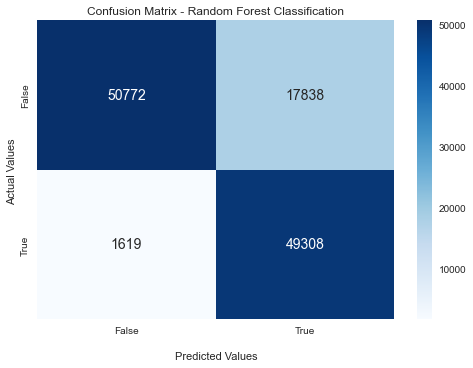

In [413]:
reduced_X_test =  X_test_class[search_RF_roc.feature_names_in_]

cf_matrix = confusion_matrix(search_RF_roc.predict(reduced_X_test), y_test_class)  
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})

ax.set_title('Confusion Matrix - Random Forest Classification');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

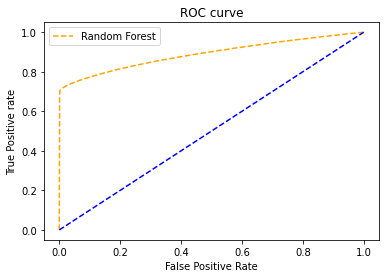

train accuracy: 0.8468%
tes accuracy: 0.8372%
Optimum number of features: 33
Best parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__n_estimators': 250}
                       feature  importance
9            vol_difference[0]    0.707066
25         realised_volatility    0.078881
29    total_average_trade_size    0.035703
12           vol_difference[1]    0.022916
0          price_difference[1]    0.022731
6          price_difference[4]    0.009733
5        price_spread_ratio[4]    0.009465
21           vol_difference[4]    0.008938
31                        hour    0.007554
8            average_price_bid    0.007509
7            average_price_ask    0.006818
11            vol_imbalance[1]    0.005952
22  accumulated_vol_difference    0.005865
18           vol_difference[3]    0.005700
15           vol_difference[2]    0.005690
4          price_difference[3]    0.005328
2          price_difference[2]    0.005324
17            vol_imbalance[3]    0.004733
27   

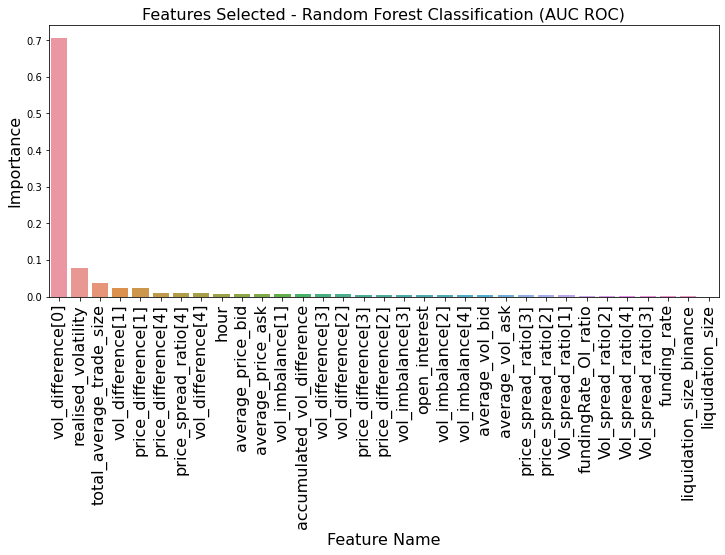

In [292]:
RF_results(search_RF_roc)

train accuracy: 0.9312%
tes accuracy: 0.8314%
Optimum number of features: 33
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 250}
                       feature  importance
9            vol_difference[0]    0.504897
25         realised_volatility    0.066549
29    total_average_trade_size    0.028881
12           vol_difference[1]    0.023562
0          price_difference[1]    0.022322
5        price_spread_ratio[4]    0.016649
23             average_vol_ask    0.016539
24             average_vol_bid    0.016538
8            average_price_bid    0.016101
11            vol_imbalance[1]    0.015972
27               open_interest    0.015732
7            average_price_ask    0.015681
14            vol_imbalance[2]    0.015107
17            vol_imbalance[3]    0.014959
6          price_difference[4]    0.014946
20            vol_imbalance[4]    0.014938
21           vol_difference[4]    0.014147
22  accumulated_vol_difference    0.013763
28  

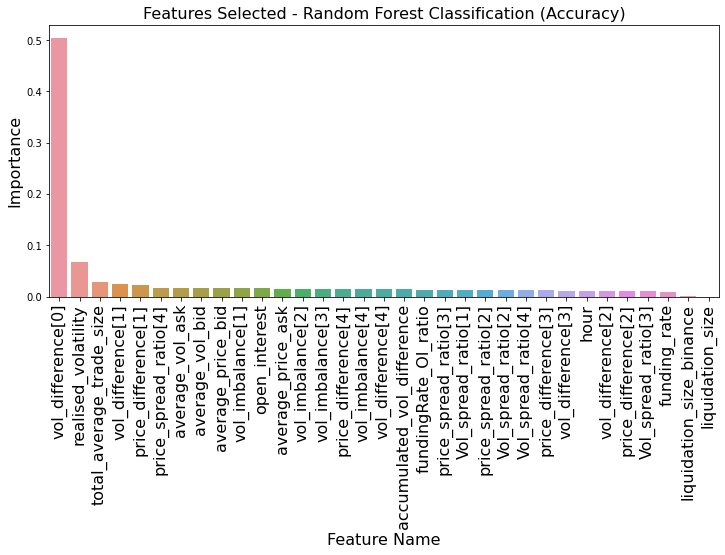

In [293]:
RF_results(search_RF_acc)

## Model Comparison
- train vs test accuracy comparison 

# Modelling Part 2

In [213]:
dataset_logRet = dataset.drop(columns='class')
dataset_logRetVol = features(ftx_book, ftx_derivative, ftx_trade, ftx_liquidations, label='log_returns(volWeighted_mid_price)')
dataset_logRetEWM = features(ftx_book, ftx_derivative, ftx_trade, ftx_liquidations, label='log_returns(mid_price)_EWM5')

invalid value encountered in sqrt
invalid value encountered in sqrt


In [252]:
dataset_logRet.columns

Index(['mid_price', 'log_returns(mid_price)', 'log_returns(mid_price)_20',
       'log_returns(mid_price)_50', 'log_returns(mid_price)_100',
       'price_spread_ratio[0]', 'price_difference[0]', 'price_spread_ratio[1]',
       'price_difference[1]', 'price_spread_ratio[2]', 'price_difference[2]',
       'price_spread_ratio[3]', 'price_difference[3]', 'price_spread_ratio[4]',
       'price_difference[4]', 'average_price_ask', 'average_price_bid',
       'Vol_spread_ratio[0]', 'vol_imbalance[0]', 'vol_difference[0]',
       'Vol_spread_ratio[1]', 'vol_imbalance[1]', 'vol_difference[1]',
       'Vol_spread_ratio[2]', 'vol_imbalance[2]', 'vol_difference[2]',
       'Vol_spread_ratio[3]', 'vol_imbalance[3]', 'vol_difference[3]',
       'Vol_spread_ratio[4]', 'vol_imbalance[4]', 'vol_difference[4]',
       'accumulated_vol_difference', 'average_vol_ask', 'average_vol_bid',
       'realised_volatility', 'funding_rate', 'open_interest',
       'fundingRate_OI_ratio', 'total_average_trade_size

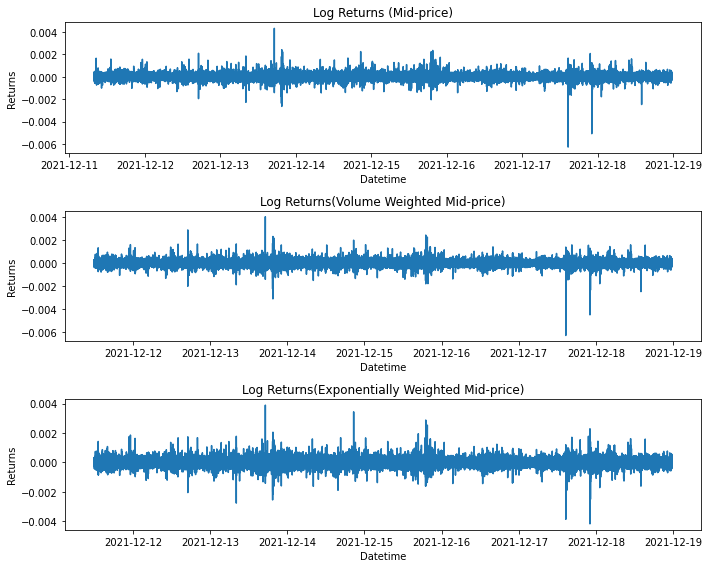

In [268]:
fig, axs = plt.subplots(3,1, figsize=(10, 8))
axs[0].plot(dataset_logRet['log_returns(mid_price)'])
axs[0].title.set_text('Log Returns (Mid-price)')
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('Returns')
axs[1].plot(dataset_logRetVol['log_returns(volWeighted_mid_price)'])
axs[1].title.set_text('Log Returns(Volume Weighted Mid-price)')
axs[1].set_xlabel('Datetime')
axs[1].set_ylabel('Returns')
axs[2].plot(dataset_logRetEWM['log_returns(mid_price)_EWM5'])
axs[2].title.set_text('Log Returns(Exponentially Weighted Mid-price)')
axs[2].set_xlabel('Datetime')
axs[2].set_ylabel('Returns')
fig.tight_layout()

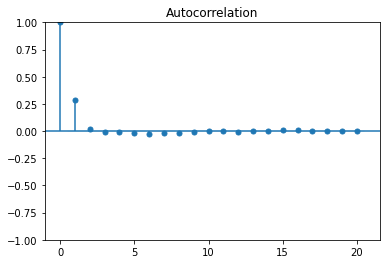

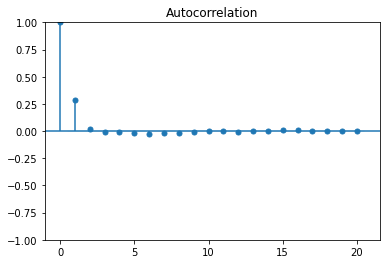

In [241]:

plot_acf(dataset_logRet['log_returns(mid_price)'], lags=20, alpha=0.05)

In [246]:
pd.DataFrame(dataset_logRet['log_returns(mid_price)'])

,log_returns(mid_price)
timestamp,
2021-12-11 07:46:03,-0.000015
2021-12-11 07:46:04,0.000035
2021-12-11 07:46:05,0.000235
2021-12-11 07:46:06,0.000037
2021-12-11 07:46:07,0.000000
...,...
2021-12-18 23:37:58,0.000000
2021-12-18 23:37:59,0.000000
2021-12-18 23:38:00,-0.000002


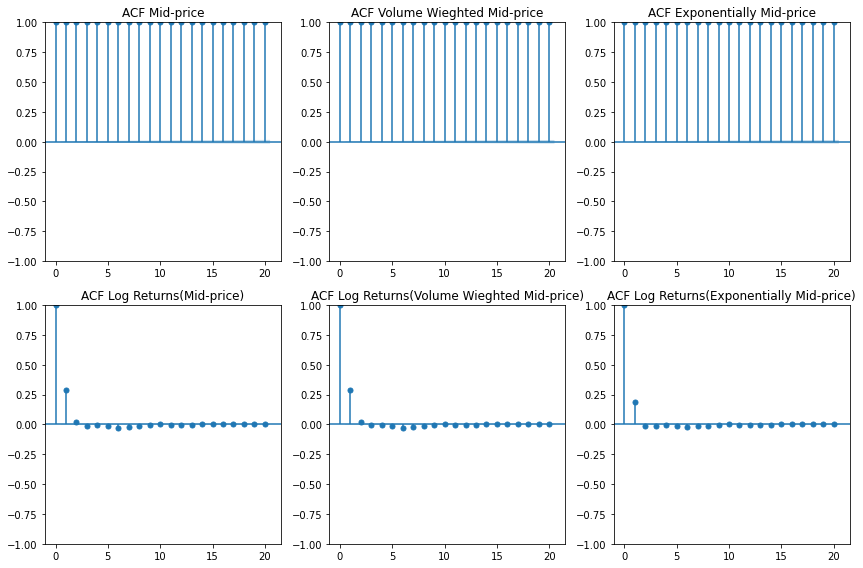

In [265]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,3, figsize=(12, 8))

sm.graphics.tsa.plot_acf(dataset_logRet['mid_price'].values, lags=20, ax=ax[0,0], title='ACF Mid-price');
sm.graphics.tsa.plot_acf(dataset_logRetVol['volWeighted_midPrice'].values, lags=20, ax=ax[0,1], title='ACF Volume Wieghted Mid-price');
sm.graphics.tsa.plot_acf(dataset_logRetEWM['expMidPrice_ftx'].values, lags=20, ax=ax[0,2], title='ACF Exponentially Mid-price');

sm.graphics.tsa.plot_acf(dataset_logRet['log_returns(mid_price)'].values, lags=20, ax=ax[1,0], title='ACF Log Returns(Mid-price)');
sm.graphics.tsa.plot_acf(dataset_logRetVol['log_returns(volWeighted_mid_price)'].values, lags=20, ax=ax[1,1], title='ACF Log Returns(Volume Wieghted Mid-price)');
sm.graphics.tsa.plot_acf(dataset_logRetEWM['log_returns(mid_price)_EWM5'].values, lags=20, ax=ax[1, 2], title='ACF Log Returns(Exponentially Mid-price)');

fig.tight_layout()

In [ ]:
plot.

In [151]:
def corrFilter(dataset, y, threshold=0.01):
    '''
     data: dataframe
     threshold: minimum correlation to y label 
    '''
    class_corr = abs(dataset.corr()[y]).sort_values(ascending=False)
    colsDrop = class_corr[(class_corr<threshold)==True].axes[0].tolist()
    dataset = dataset.drop(columns=colsDrop)
    return dataset

dataset_logRet = corrFilter(dataset_logRet, y='log_returns(mid_price)')
dataset_logRetVol = corrFilter(dataset_logRetVol, y='log_returns(volWeighted_mid_price)')
dataset_logRetEWM = corrFilter(dataset_logRetEWM, y='log_returns(mid_price)_EWM5')

print(dataset_logRet.shape)
print(dataset_logRetVol.shape)
print(dataset_logRetEWM.shape)

(597685, 18)
(646950, 18)
(646985, 18)


- split dataset into train and test sets for each y label

In [154]:
train_ds_logRet, test_ds_logRet = train_test_split(dataset_logRet, train_split=0.8)
train_ds_logRetVol, test_ds_logRetVol = train_test_split(dataset_logRetVol, train_split=0.8)
train_ds_logRetEWM, test_ds_logRetEWM = train_test_split(dataset_logRetEWM, train_split=0.8)

- For each labels' train and test set, split into X and y 

In [155]:
def XySplit(train_ds, test_ds, label):
    label_count=1
    
    X_train = train_ds.iloc[:, label_count:]
    y_train = train_ds[label]

    X_test = test_ds.iloc[:, label_count:]
    y_test = test_ds[label]
    
    return X_train, y_train, X_test, y_test


X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet = XySplit(train_ds=train_ds_logRet, 
                                                                       test_ds=test_ds_logRet, 
                                                                       label='log_returns(mid_price)')

X_train_logRetVol, y_train_logRetVol, X_test_logRetVol, y_test_logRetVol = XySplit(train_ds=train_ds_logRetVol, 
                                                                       test_ds=test_ds_logRetVol, 
                                                                       label='log_returns(volWeighted_mid_price)')

X_train_logRetEWM, y_train_logRetEWM, X_test_logRetEWM, y_test_logRetEWM = XySplit(train_ds=train_ds_logRetEWM, 
                                                                       test_ds=test_ds_logRetEWM, 
                                                                       label='log_returns(mid_price)_EWM5')

## Ridge Regression

- repeat cross validation for linear regression as well

In [316]:
def rmse(y_true,y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return rmse

class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

def RidgeModel(X_train, y_train, X_test, y_test, label, metric):

    #RFECV
    model = Ridge()
    tscv = TimeSeriesSplit(n_splits = 5)
    pipeline  = MyPipeline([('scaler', MinMaxScaler()), ('model', model)])
    
    if metric == 'mae':
        scorer = 'neg_mean_absolute_error'
    elif metric == 'mse':
        scorer = 'neg_mean_squared_error'
    elif metric == 'rmse':
        scorer = make_scorer(rmse, greater_is_better=False)
    
    regr_Ridge = RFECV(pipeline, step=1, min_features_to_select=15, cv=tscv, scoring=scorer)
    
    regr_Ridge.fit(X_train, y_train)
    reduced_X_train = X_train.iloc[:,regr_Ridge.support_]
    
    #parameter tuning
    param_grid = {'model__alpha': sorted(np.logspace(-1, 2, 4))}
    search_Ridge = GridSearchCV(pipeline,
                          param_grid=param_grid,
                          scoring=scorer,
                          n_jobs=-1,
                          cv=tscv,
                          verbose=2)

    search_Ridge.fit(reduced_X_train, y_train)
    
    #save model
    filename = 'RidgeRegr_' + metric + "_" + label + '.sav'
    joblib.dump(search_Ridge , filename)
    
    
    #predicted
    reduced_X_train = X_train[search_Ridge.feature_names_in_]
    reduced_X_test = X_test[search_Ridge.feature_names_in_]
    
    predicted_train = search_Ridge.predict(reduced_X_train)
    predicted_test = search_Ridge.predict(reduced_X_test)
    
    if metric == 'mae':
        Ridge_train = mean_absolute_error(y_train, predicted_train)
        Ridge_test = mean_absolute_error(y_test, predicted_test)
    
    elif metric == 'mse':
        Ridge_train = mean_squared_error(y_train, predicted_train)
        Ridge_test = mean_squared_error(y_test, predicted_test)
    
    elif metric == 'rmse':
        Ridge_train = rmse(y_train, predicted_train)
        Ridge_test = rmse(y_test, predicted_test)
    
    print(label)
    print("train {}: {:.10f}".format(metric, Ridge_train))
    print("test {}: {:.10f}".format(metric, Ridge_test))
    print("ALPHA: {}".format(search_Ridge.best_params_))
    print("Optimum number of features: {}".format(len(search_Ridge.feature_names_in_)))

    #coefficients
    feature_names = search_Ridge.feature_names_in_
    feature_coefs = search_Ridge.best_estimator_.coef_.flatten()
    features = pd.DataFrame(zip(feature_names, feature_coefs), columns=['feature', 'coefficient'])
    features['abs_coef'] = abs(feature_coefs)
    features["colors"] = features["coefficient"].apply(lambda x: "green" if x > 0 else "red")
    features = features.sort_values("abs_coef", ascending=False)
    print(features)

    #plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    sns.barplot(x="feature",
                y="coefficient",
                data=features,
               palette=features["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    ax.set_title("Ridge Regression, Features Selected {}, {}".format(metric, label), fontsize=16)
    ax.set_ylabel("Coefficient", fontsize=16)
    ax.set_xlabel("Feature Name", fontsize=16)

- Ridge for log_returns(mid_price)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
logRet
train mae: 0.0000581195
test mae: 0.0000568082
ALPHA: {'model__alpha': 10.0}
Optimum number of features: 17
                           feature  coefficient  abs_coef colors
16  log_returns(mid_price)_binance     0.001803  0.001803  green
15                             t-1    -0.000193  0.000193    red
14        total_average_trade_size     0.000092  0.000092  green
7                vol_difference[0]     0.000073  0.000073  green
4              price_difference[0]     0.000073  0.000073  green
6                 vol_imbalance[0]     0.000069  0.000069  green
3            price_spread_ratio[0]     0.000054  0.000054  green
0        log_returns(mid_price)_20    -0.000050  0.000050    red
2       log_returns(mid_price)_100    -0.000044  0.000044    red
5              Vol_spread_ratio[0]     0.000042  0.000042  green
1        log_returns(mid_price)_50     0.000041  0.000041  green
8                 vol_imbalance[1]     0.0000

Fitting 5 folds for each of 4 candidates, totalling 20 fits
logRet
train rmse: 0.0001002968
test rmse: 0.0000994427
ALPHA: {'model__alpha': 1.0}
Optimum number of features: 17
                           feature  coefficient  abs_coef colors
16  log_returns(mid_price)_binance     0.001938  0.001938  green
15                             t-1    -0.000218  0.000218    red
14        total_average_trade_size     0.000205  0.000205  green
7                vol_difference[0]     0.000135  0.000135  green
4              price_difference[0]     0.000135  0.000135  green
5              Vol_spread_ratio[0]     0.000112  0.000112  green
6                 vol_imbalance[0]     0.000067  0.000067  green
3            price_spread_ratio[0]    -0.000065  0.000065    red
0        log_returns(mid_price)_20    -0.000058  0.000058    red
1        log_returns(mid_price)_50     0.000048  0.000048  green
2       log_returns(mid_price)_100    -0.000047  0.000047    red
8                 vol_imbalance[1]     0.000

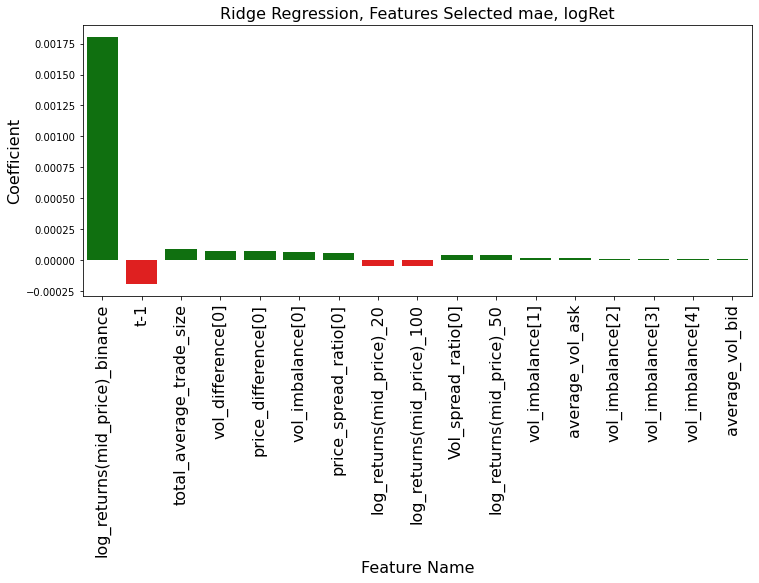

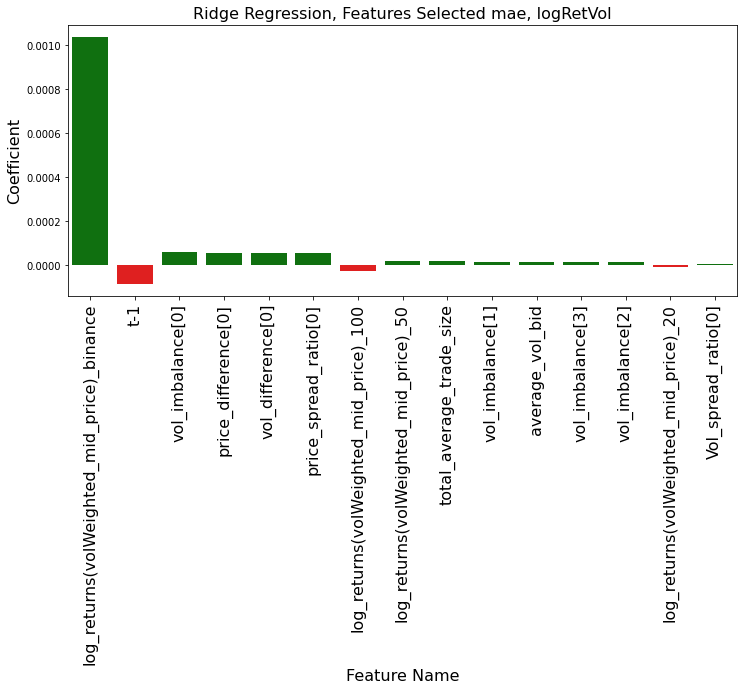

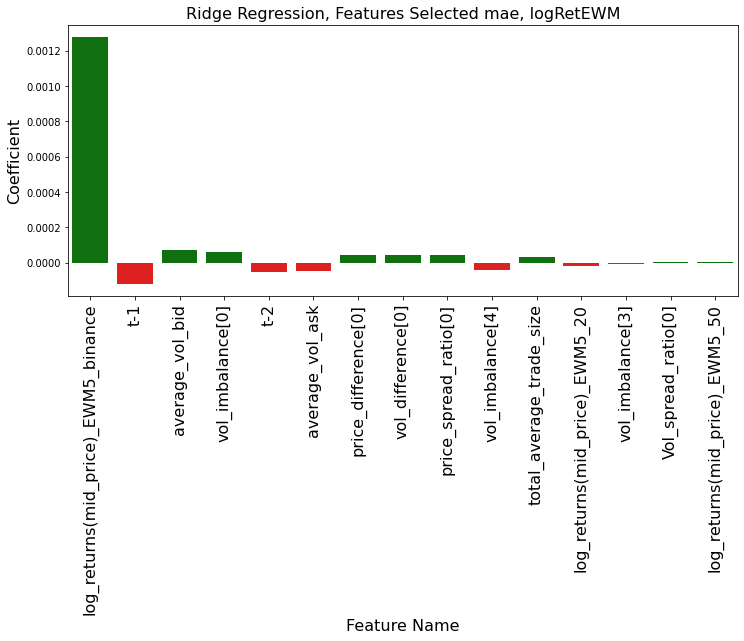

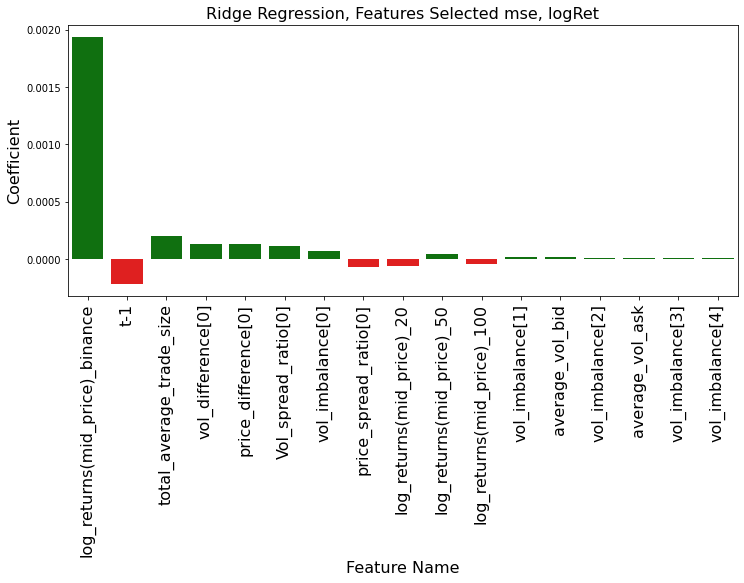

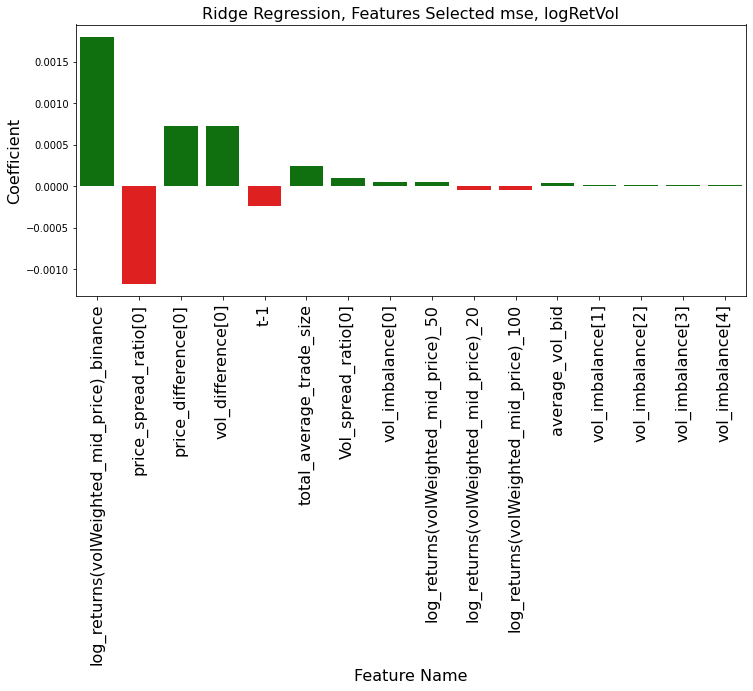

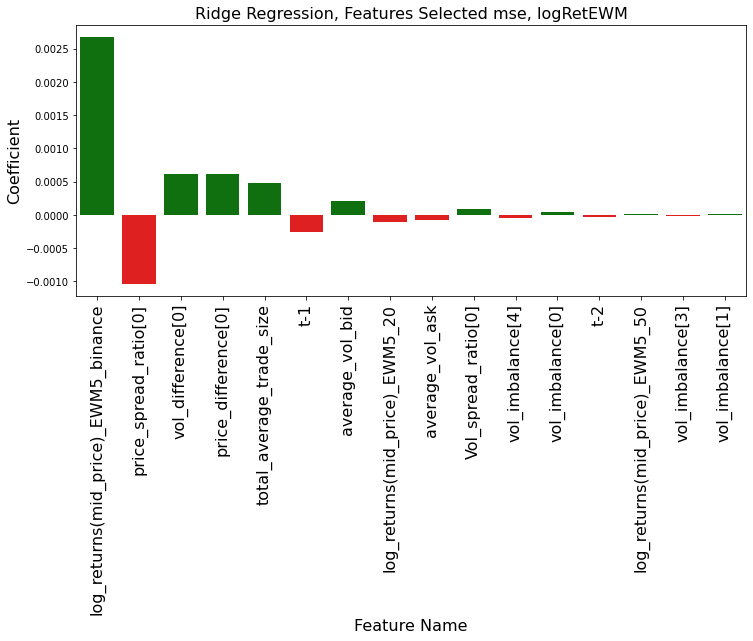

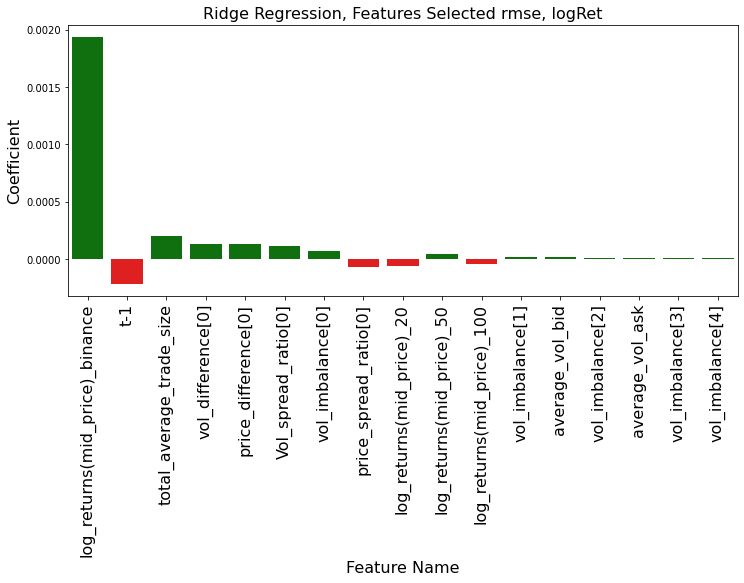

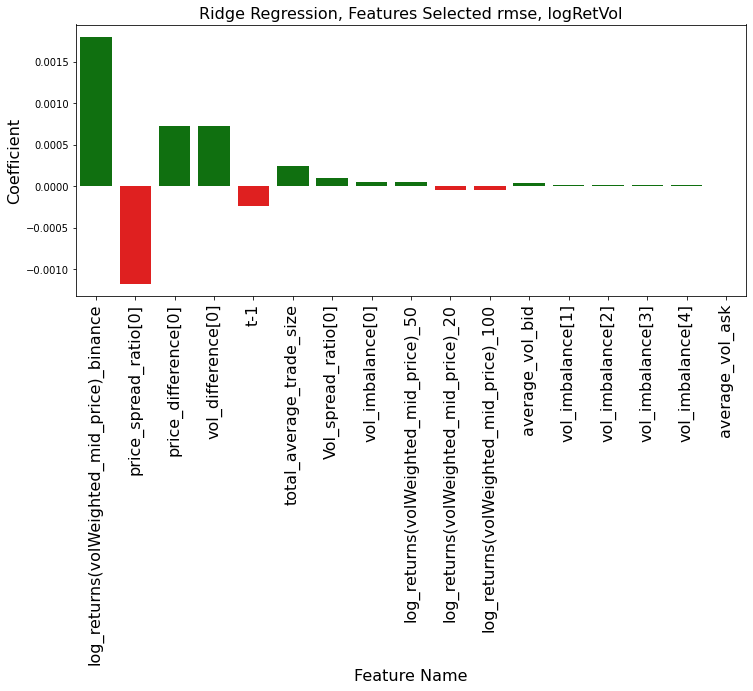

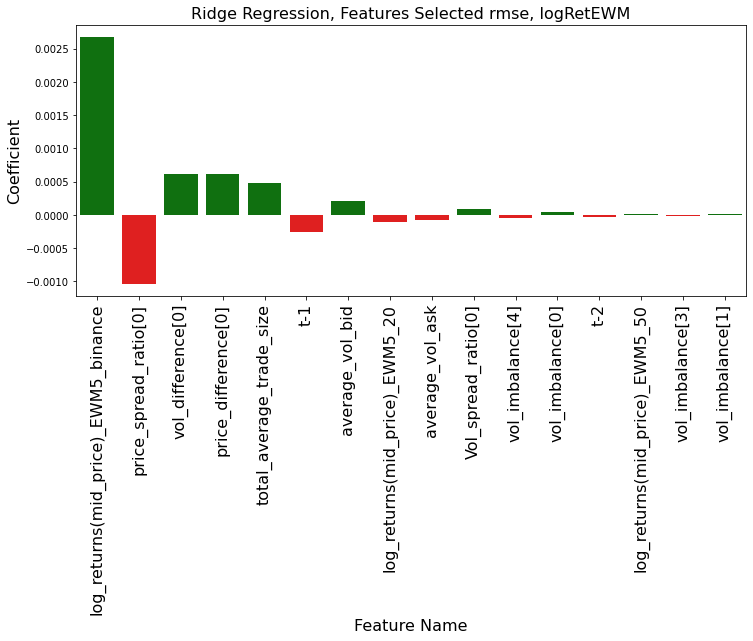

In [317]:
metric_labels = ['mae', 'mse', 'rmse']
for metrics in metric_labels:
        RidgeModel(X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet, label='logRet', metric=metrics)
        RidgeModel(X_train_logRetVol, y_train_logRetVol, X_test_logRetVol, y_test_logRetVol, label='logRetVol', metric=metrics)
        RidgeModel(X_train_logRetEWM, y_train_logRetEWM, X_test_logRetEWM, y_test_logRetEWM, label='logRetEWM', metric=metrics)

## Random Forest Regression

- cross validation with 5 splits performed the best with lowest average MSE

In [45]:
# train = pd.concat([train_ds, valid_ds], axis=0)
# X = train.iloc[:, 2:]
# y = train['log_returns(mid_price)']

# rf_reg = RandomForestRegressor(n_jobs=-1,
#                                 random_state=42,
#                                  )e
# scoreBoard = {}

# # Fit the model
# n_splits = [3 , 5, 10]
# for split in n_splits:
#     tscv = TimeSeriesSplit(n_splits = split)
#     scores = cross_val_score(
#         estimator = rf_reg,
#         X = X,
#         y = y,
#         cv = tscv,
#         scoring = 'neg_mean_squared_error')
#     print("CV_{}_average: {}".format(split, np.mean(abs(scores))))


In [134]:
class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_
    
def RF_metrics(X_train, y_train, X_test, y_test, label, metric):
    #RFECV
    model = RandomForestRegressor(n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits = 5)
    pipeline  = MyPipeline([('scaler', MinMaxScaler()), ('model', model)]) 
    
    if metric == 'mae':
        scorer = 'neg_mean_absolute_error'
    elif metric == 'mse':
        scorer = 'neg_mean_squared_error'
    elif metric == 'rmse':
        scorer = make_scorer(rmse, greater_is_better=False)
    
    regr_RF = RFECV(pipeline, step=1, min_features_to_select=10, cv=tscv, scoring=scorer)
    
    regr_RF.fit(X_train, y_train)
    reduced_X_train = X_train.iloc[:,regr_RF.support_]
    
    #parameter tuning
    param_grid = {'model__n_estimators': [50, 100, 250],
              'model__max_depth': [5, 15, None],
              'model__min_samples_leaf': [5, 25, 100]}

    search_RF = GridSearchCV(pipeline,
                          param_grid=param_grid,
                          scoring=scorer,
                          n_jobs=-1,
                          cv=tscv,
                          verbose=2)
    
    search_RF.fit(reduced_X_train, y_train)
    
    #save model
    filename = 'RFRegr_' + metric + "_"+ label + '.sav'
    joblib.dump(search_RF, filename)
    
    #predicted
    reduced_X_train = X_train[search_RF.feature_names_in_]
    reduced_X_test = X_test[search_RF.feature_names_in_]
    
    predicted_train = search_RF.predict(reduced_X_train)
    predicted_test = search_RF.predict(reduced_X_test)
    
    if metric == 'mae':
        rmse_RF_train = mean_absolute_error(y_train, predicted_train)
        rmse_RF_test = mean_absolute_error(y_test, predicted_test)
    
    elif metric == 'mse':
        rmse_RF_train = mean_squared_error(y_train, predicted_train)
        rmse_RF_test = mean_squared_error(y_test, predicted_test)
    
    elif metric == 'rmse':
        rmse_RF_train = rmse(y_train, predicted_train)
        rmse_RF_test = rmse(y_test, predicted_test)
    
    print(label)
    print("Train {}: {:.10f}".format(metric, rmse_RF_train))
    print("Test {}: {:.10f}".format(metric, rmse_RF_test))
    print("Best parameters: {}".format(search_RF.best_params_))
    print("Optimum number of features: {}".format(len(search_RF.feature_names_in_)))

    #Importance
    feature_names = search_RF.feature_names_in_.flatten()
    feature_importances = search_RF.best_estimator_.feature_importances_.flatten()
    features = pd.DataFrame(zip(feature_names, feature_importances), columns=['feature', 'importance'])
    features = features.sort_values("importance", ascending=False)
    print(features)

    #plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    sns.barplot(x="feature",
                y="importance",
                data=features)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    ax.set_title("Random Forest Features Selected", fontsize=16)
    ax.set_ylabel("Importance", fontsize=16)
    ax.set_xlabel("Feature Name", fontsize=16)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
logRet
Train mae: 0.0000447280
Test mae: 0.0000470392
Best parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__n_estimators': 100}
Optimum number of features: 16
                         feature  importance
15  log_returnsmid_price_binance    0.346851
5                 vol_imbalance0    0.117853
3            price_spread_ratio0    0.108578
4              price_difference0    0.083457
6                vol_difference0    0.081376
13      total_average_trade_size    0.073904
14                            t1    0.035766
0        log_returnsmid_price_20    0.022836
7                 vol_imbalance1    0.019957
2       log_returnsmid_price_100    0.017411
11               average_vol_ask    0.017211
1        log_returnsmid_price_50    0.015862
12               average_vol_bid    0.015859
8                 vol_imbalance2    0.014605
10                vol_imbalance4    0.014482
9                 vol_imbalance3

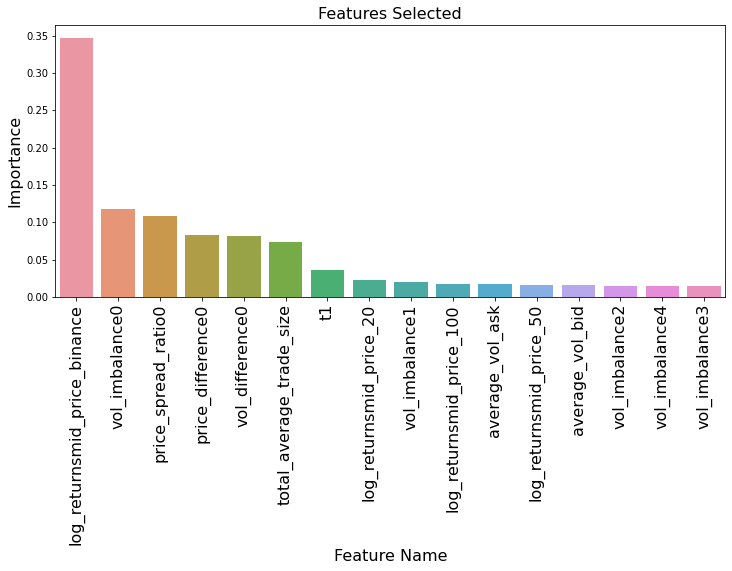

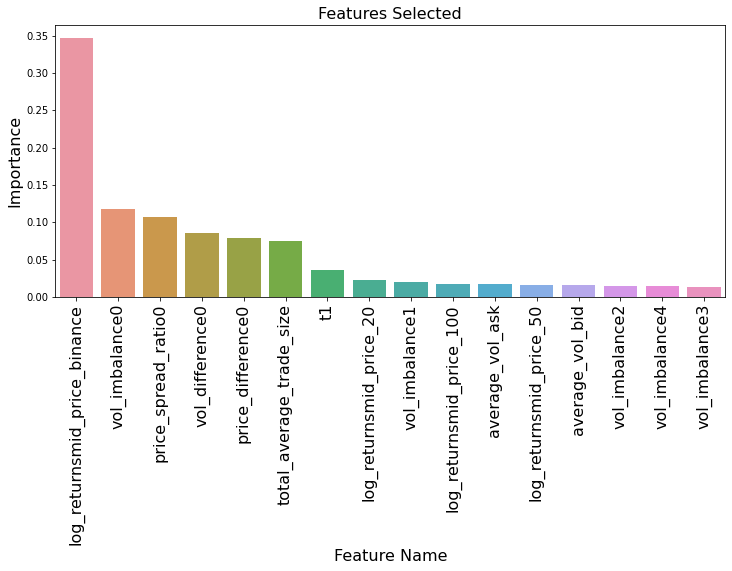

In [135]:
metric_labels = ['mae', 'mse']
for metrics in metric_labels:
        RF_metrics(X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet, label='logRet', metric=metrics)
#         RF_metrics(X_train_logRetVol, y_train_logRetVol, X_test_logRetVol, y_test_logRetVol, label='logRetVol', metric=metrics)
#         RF_metrics(X_train_logRetEWM, y_train_logRetEWM, X_test_logRetEWM, y_test_logRetEWM, label='logRetEWM', metric=metrics)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Train RMSE: 0.0000805839
Test RMSE: 0.0000892729
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 25, 'model__n_estimators': 250}
Optimum number of features: 17
                           feature  importance
16  log_returns(mid_price)_binance    0.318105
6                 vol_imbalance[0]    0.109052
3            price_spread_ratio[0]    0.102340
4              price_difference[0]    0.078901
7                vol_difference[0]    0.077353
14        total_average_trade_size    0.072633
15                             t-1    0.037324
0        log_returns(mid_price)_20    0.028011
8                 vol_imbalance[1]    0.025179
2       log_returns(mid_price)_100    0.022429
12                 average_vol_ask    0.021959
1        log_returns(mid_price)_50    0.021464
13                 average_vol_bid    0.021001
9                 vol_imbalance[2]    0.020272
11                vol_imbalance[4]    0.019464
10 

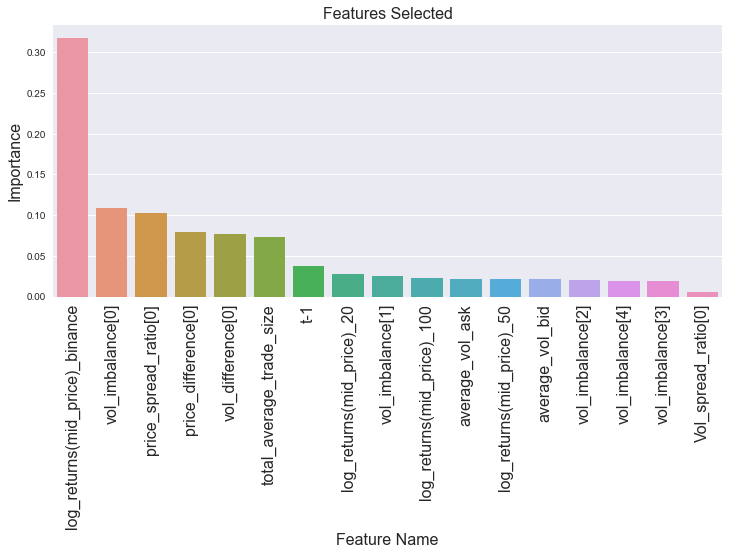

In [392]:
%%time
RF_metrics(X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet, label='logRet')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Train RMSE: 0.0000817478
Test RMSE: 0.0000880681
Best parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__n_estimators': 250}
Optimum number of features: 17
                                       feature  importance
16  log_returns(volWeighted_mid_price)_binance    0.339513
3                        price_spread_ratio[0]    0.102093
6                             vol_imbalance[0]    0.097979
14                    total_average_trade_size    0.085753
4                          price_difference[0]    0.084623
7                            vol_difference[0]    0.079947
15                                         t-1    0.040841
0        log_returns(volWeighted_mid_price)_20    0.024367
8                             vol_imbalance[1]    0.021649
12                             average_vol_ask    0.018755
2       log_returns(volWeighted_mid_price)_100    0.018207
1        log_returns(volWeighted_mid_price)_50   

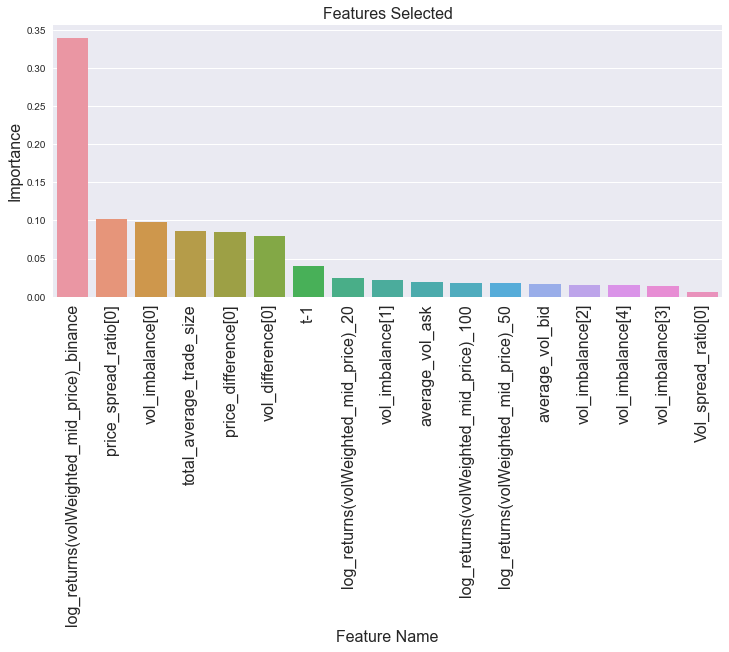

In [393]:
%%time
RF_metrics(X_train_logRetVol, y_train_logRetVol, X_test_logRetVol, y_test_logRetVol, label='logRetVol')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Train RMSE: 0.0000817534
Test RMSE: 0.0000880801
Best parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__n_estimators': 250}
Optimum number of features: 16
                                       feature  importance
15  log_returns(volWeighted_mid_price)_binance    0.340318
5                             vol_imbalance[0]    0.104718
3                        price_spread_ratio[0]    0.098751
4                          price_difference[0]    0.087603
13                    total_average_trade_size    0.084731
6                            vol_difference[0]    0.080629
14                                         t-1    0.040845
0        log_returns(volWeighted_mid_price)_20    0.024244
7                             vol_imbalance[1]    0.021766
11                             average_vol_ask    0.018597
2       log_returns(volWeighted_mid_price)_100    0.018302
1        log_returns(volWeighted_mid_price)_50   

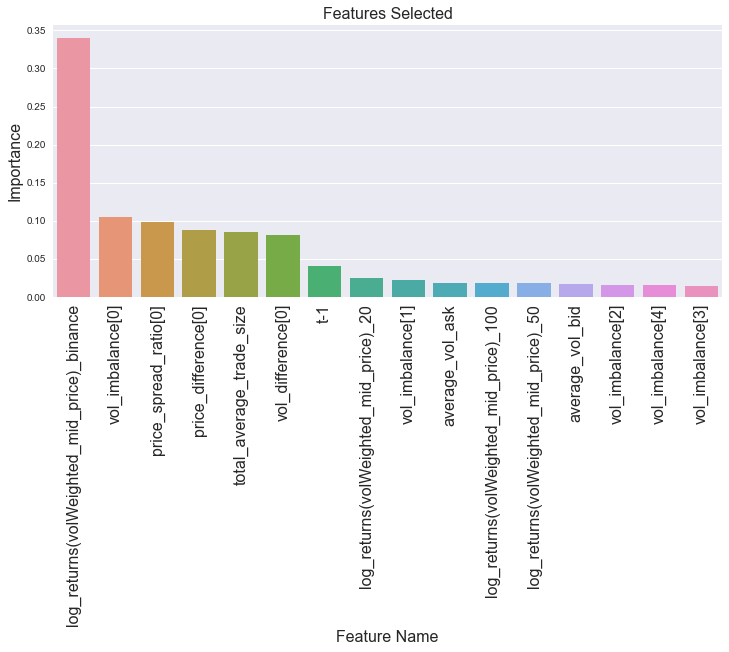

In [394]:
%%time
RF_metrics(X_train_logRetVol, y_train_logRetVol, X_test_logRetVol, y_test_logRetVol, label='logRetEWM')

# LGBM

In [98]:
def LGBM_metrics(X_train, y_train, X_test, y_test, label, metric):
    model = lgb.LGBMRegressor(n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits = 5)

    if metric == 'mae':
        scorer = 'neg_mean_absolute_error'
    elif metric == 'mse':
        scorer = 'neg_mean_squared_error'
    elif metric == 'rmse':
        scorer = make_scorer(rmse, greater_is_better=False)

    regr_LGBM = RFECV(model, step=1, min_features_to_select=10, cv=tscv, scoring=scorer)

    regr_LGBM.fit(X_train, y_train)
    reduced_X_train = X_train.iloc[:,regr_LGBM.support_]

    #parameter tuning
    param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}

    search_light = GridSearchCV(
        estimator=lgb.LGBMRegressor(),
        param_grid=param_grid,
        scoring=scorer,
        cv=TimeSeriesSplit(n_splits=5),
        verbose=2,
        n_jobs=-1,
    )

    search_light.fit(reduced_X_train, y_train)

    #save model
    filename = 'LGBM_' + metric + "_" + label + '.sav'
    joblib.dump(search_light.fit, filename)

    #predicted
    reduced_X_train = X_train[reduced_X_train.columns]
    reduced_X_test = X_test[reduced_X_train.columns]

    predicted_train = search_light.predict(reduced_X_train)
    predicted_test = search_light.predict(reduced_X_test)

    if metric == 'mae':
        rmse_LGBM_train = mean_absolute_error(y_train, predicted_train)
        rmse_LGBM_test = mean_absolute_error(y_test, predicted_test)

    elif metric == 'mse':
        rmse_LGBM_train = mean_squared_error(y_train, predicted_train)
        rmse_LGBM_test = mean_squared_error(y_test, predicted_test)

    elif metric == 'rmse':
        rmse_LGBM_train = rmse(y_train, predicted_train)
        rmse_LGBM_test = rmse(y_test, predicted_test)

    print(label)
    print("Train {}: {:.10f}".format(metric, rmse_LGBM_train))
    print("Test {}: {:.10f}".format(metric, rmse_LGBM_test))
    print("Best parameters: {}".format(search_light.best_params_))
    print("Optimum number of features: {}".format(search_light.n_features_in_))

    #Importance
    feature_names = reduced_X_train.columns
    feature_importances = search_light.best_estimator_.feature_importances_.flatten()
    features = pd.DataFrame(zip(feature_names, feature_importances), columns=['feature', 'importance'])
    features = features.sort_values("importance", ascending=False)
    print(features)

    #plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    sns.barplot(x="feature",
                y="importance",
                data=features)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    ax.set_title("Features Selected", fontsize=16)
    ax.set_ylabel("Importance", fontsize=16)
    ax.set_xlabel("Feature Name", fontsize=16)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
logRet
Train mae: 0.0000476477
Test mae: 0.0000459423
Best parameters: {'max_depth': 5, 'min_samples_leaf': 25, 'n_estimators': 50}
Optimum number of features: 12
                         feature  importance
9       total_average_trade_size         293
2              price_difference0         276
11  log_returnsmid_price_binance         221
3              Vol_spread_ratio0         216
10                            t1         162
0        log_returnsmid_price_20          78
4                 vol_imbalance1          42
6                 vol_imbalance4          40
7                average_vol_ask          38
1       log_returnsmid_price_100          34
8                average_vol_bid          32
5                 vol_imbalance2          29
Fitting 5 folds for each of 27 candidates, totalling 135 fits
logRetVol
Train mae: 0.0000456910
Test mae: 0.0000449249
Best parameters: {'max_depth': None, 'min_samples_leaf': 100, 'n_estima

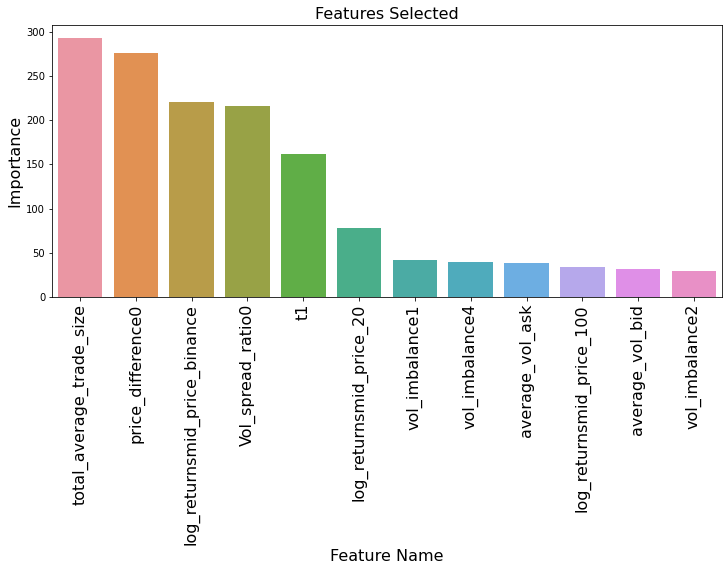

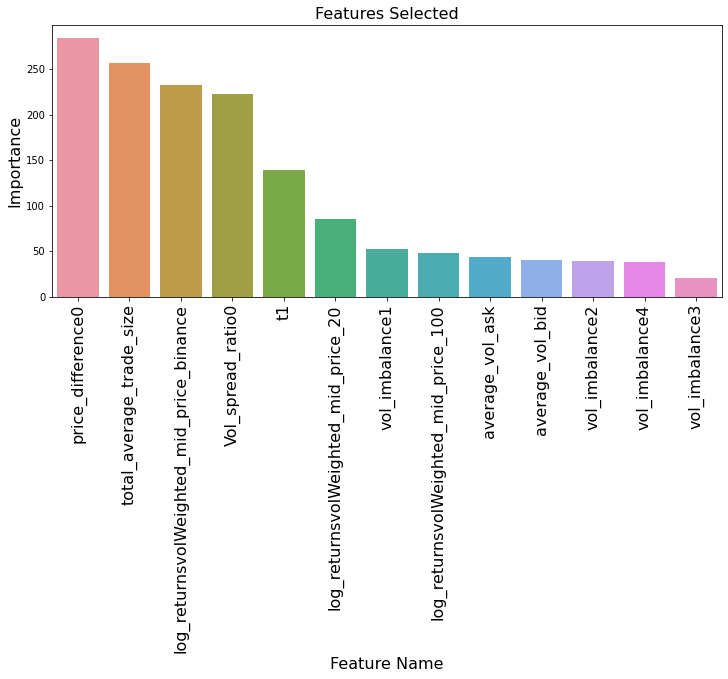

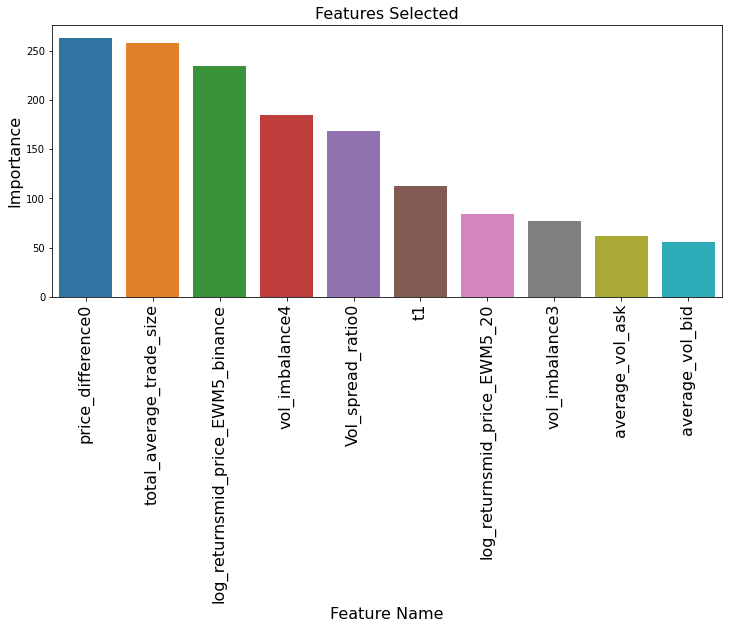

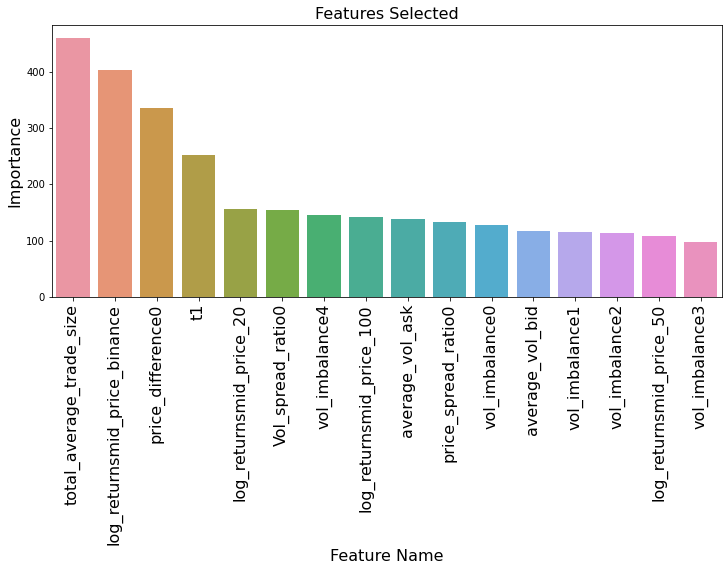

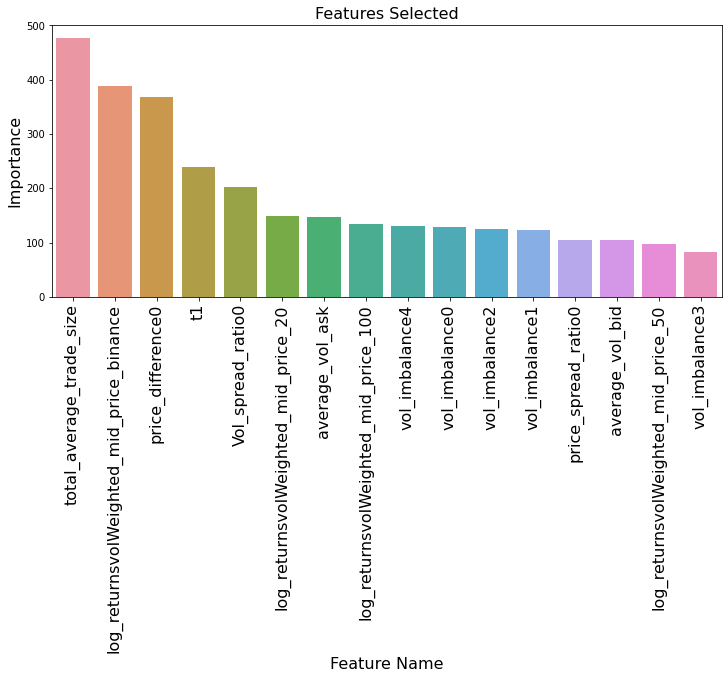

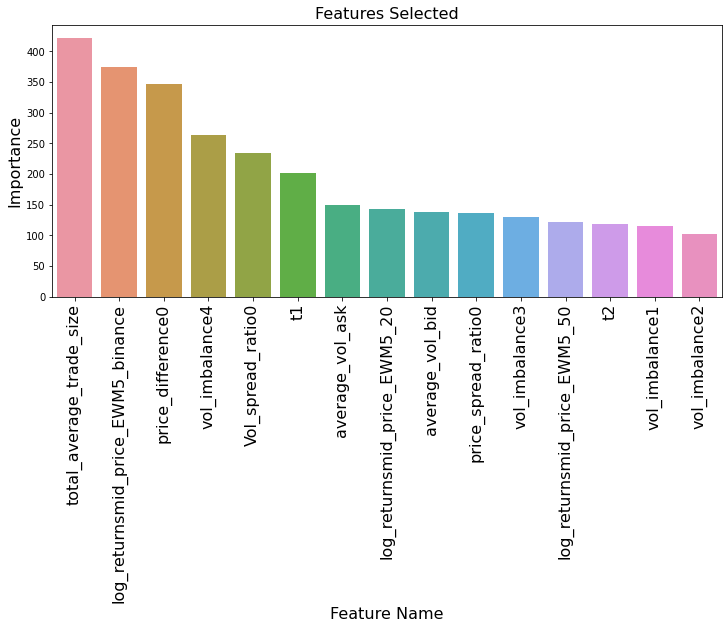

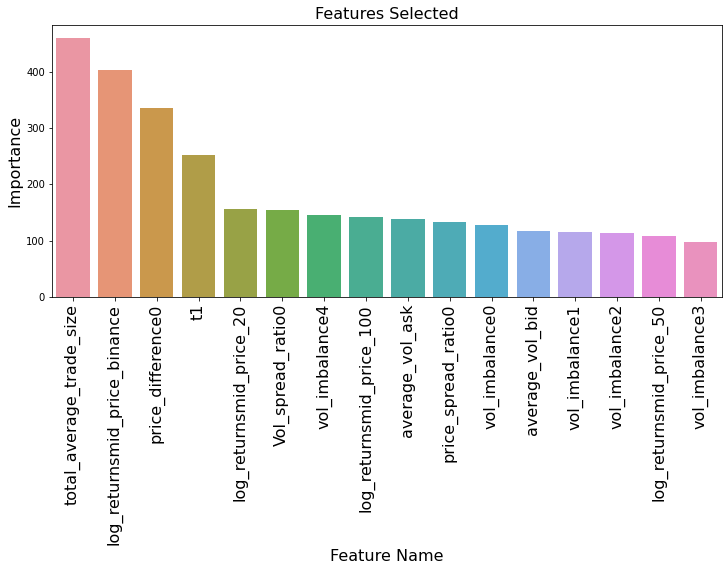

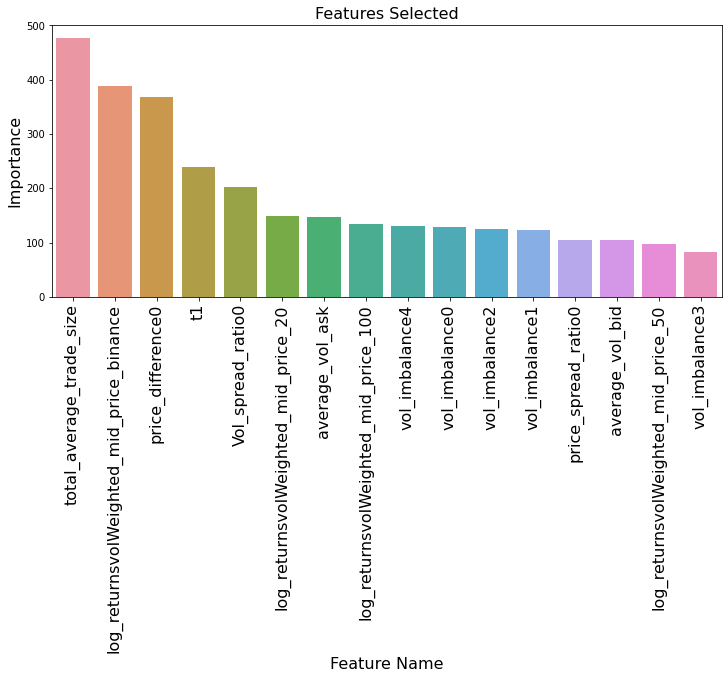

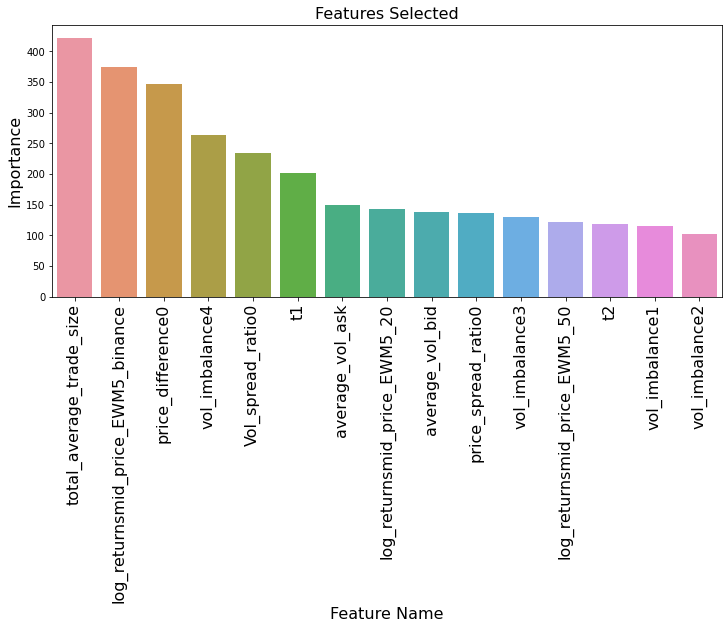

In [99]:
%%time
X_train_logRet = X_train_logRet.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_logRet = X_test_logRet.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_logRetVol = X_train_logRetVol.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_logRetVol = X_test_logRetVol.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_logRetEWM = X_train_logRetEWM.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_logRetEWM = X_test_logRetEWM.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

metric_labels = ['mae', 'mse', 'rmse']
for metrics in metric_labels:
        LGBM_metrics(X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet, label='logRet', metric=metrics)
        LGBM_metrics(X_train_logRetVol, y_train_logRetVol, X_test_logRetVol, y_test_logRetVol, label='logRetVol', metric=metrics)
        LGBM_metrics(X_train_logRetEWM, y_train_logRetEWM, X_test_logRetEWM, y_test_logRetEWM, label='logRetEWM', metric=metrics)


# Hurdle Model

In [100]:
RFClass_logRet = joblib.load("RFClass_accuracy.sav")
LogisticReg_logRet = joblib.load("logisticReg_accuracy.sav")

mae_logRet = joblib.load("LGBM_mae_logRet.sav")
mse_logRet = joblib.load("LGBM_mse_logRet.sav")
rmse_logRet = joblib.load("LGBM_rmse_logRet.sav")

## Train

- Get predicted probabilities from LR and RF 

In [120]:
def LGBM_metrics(X_train, y_train, X_test, y_test, label, metric):
    model = lgb.LGBMRegressor(n_jobs=-1)
    tscv = TimeSeriesSplit(n_splits = 5)

    if metric == 'mae':
        scorer = 'neg_mean_absolute_error'
    elif metric == 'mse':
        scorer = 'neg_mean_squared_error'
    elif metric == 'rmse':
        scorer = make_scorer(rmse, greater_is_better=False)

    regr_LGBM = RFECV(model, step=1, min_features_to_select=10, cv=tscv, scoring=scorer)

    regr_LGBM.fit(X_train, y_train)
    reduced_X_train = X_train.iloc[:,regr_LGBM.support_]

    #parameter tuning
    param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}

    search_light = GridSearchCV(
        estimator=lgb.LGBMRegressor(),
        param_grid=param_grid,
        scoring=scorer,
        cv=TimeSeriesSplit(n_splits=5),
        verbose=2,
        n_jobs=-1,
    )

    return reduced_X_train, search_light.fit(reduced_X_train, y_train)
metric='logRet'

features_mae, mae_logRet = LGBM_metrics(X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet, label='logRet', metric='mae')
features_mse, mse_logRet = LGBM_metrics(X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet, label='logRet', metric='mse')
features_rmse, rmse_logRet = LGBM_metrics(X_train_logRet, y_train_logRet, X_test_logRet, y_test_logRet, label='logRet', metric='rmse')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [136]:
#get the reduced features
LR_features = X_test_class[LogisticReg_logRet.feature_names_in_]
RF_features = X_test_class[RFClass_logRet.feature_names_in_]

#compute proba
LR_proba = LogisticReg_logRet.predict_proba(LR_features)
RFClass_proba = RFClass_logRet.predict_proba(RF_features)

#get features
features_mae = X_test_logRet[features_mae.columns]
features_mse = X_test_logRet[features_mse.columns]
features_rmse = X_test_logRet[features_rmse.columns]

#predict proba
mae_pred = mae_logRet.predict(features_mae)
mse_pred = mse_logRet.predict(features_mse)
rmse_pred = rmse_logRet.predict(features_rmse)

#LR
mae_newPred_LR = LR_proba[:,1]*mae_pred
mse_newPred_LR = LR_proba[:,1]*mse_pred
rmse_newPred_LR = LR_proba[:,1]*rmse_pred

#RF
mae_newPred_RF = RFClass_proba[:,1]*mae_pred
mse_newPred_RF = RFClass_proba[:,1]*mse_pred
rmse_newPred_RF = RFClass_proba[:,1]*rmse_pred

print('LR')
print('{:.10f}'.format(mean_absolute_error(y_test_logRet, mae_newPred_LR)))
print('{:.10f}'.format(mean_squared_error(y_test_logRet, mse_newPred_LR)))
print('{:.10f}'.format(rmse(y_test_logRet, rmse_newPred_LR)))
print('RF')
print('{:.10f}'.format(mean_absolute_error(y_test_logRet, mae_newPred_RF)))
print('{:.10f}'.format(mean_squared_error(y_test_logRet, mse_newPred_RF)))
print('{:.10f}'.format(rmse(y_test_logRet, rmse_newPred_RF)))


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Vol_spread_ratio0
Feature names seen at fit time, yet now missing:
- log_returnsmid_price_50
- price_spread_ratio0
- vol_difference0
- vol_imbalance0
- vol_imbalance3



ValueError: X has 12 features, but MinMaxScaler is expecting 16 features as input.

In [206]:
mae_logRet_features = ['log_returns(mid_price)_20',
 'log_returns(mid_price)_50',
 'log_returns(mid_price)_100',
 'price_spread_ratio[0]',
 'price_difference[0]',
 'vol_imbalance[0]',
 'vol_difference[0]',
 'vol_imbalance[1]',
 'vol_imbalance[2]',
 'vol_imbalance[3]',
 'vol_imbalance[4]',
 'average_vol_ask',
 'average_vol_bid',
 'total_average_trade_size',
 't-1',
 'log_returns(mid_price)_binance']

In [207]:
mse_logRet_features = ['log_returns(mid_price)_20',
 'log_returns(mid_price)_50',
 'log_returns(mid_price)_100',
 'price_spread_ratio[0]',
 'price_difference[0]',
 'vol_imbalance[0]',
 'vol_difference[0]',
 'vol_imbalance[1]',
 'vol_imbalance[2]',
 'vol_imbalance[3]',
 'vol_imbalance[4]',
 'average_vol_ask',
 'average_vol_bid',
 'total_average_trade_size',
 't-1',
 'log_returns(mid_price)_binance']

In [179]:
list(X_train_logRet.columns)

['log_returns(mid_price)_20',
 'log_returns(mid_price)_50',
 'log_returns(mid_price)_100',
 'price_spread_ratio[0]',
 'price_difference[0]',
 'Vol_spread_ratio[0]',
 'vol_imbalance[0]',
 'vol_difference[0]',
 'vol_imbalance[1]',
 'vol_imbalance[2]',
 'vol_imbalance[3]',
 'vol_imbalance[4]',
 'average_vol_ask',
 'average_vol_bid',
 'total_average_trade_size',
 't-1',
 'log_returns(mid_price)_binance']

In [208]:
RFClass_logRet = joblib.load("RFClass_accuracy.sav")
LogisticReg_logRet = joblib.load("logisticReg_accuracy.sav")

mae_logRet = joblib.load("RFRegr_mae_logRet.sav")
mse_logRet = joblib.load("RFRegr_mse_logRet.sav")
rmse_logRet = joblib.load("RFRegr_rmse_logRet.sav")

#get the reduced features
LR_features = X_train_class[LogisticReg_logRet.feature_names_in_]
RF_features = X_train_class[RFClass_logRet.feature_names_in_]

#compute proba
LR_proba = LogisticReg_logRet.predict_proba(LR_features)
RFClass_proba = RFClass_logRet.predict_proba(RF_features)

#get features
features_mae = X_train_logRet[mae_logRet_features]
features_mse = X_train_logRet[mse_logRet_features]
features_rmse = X_train_logRet[rmse_logRet.feature_names_in_]

#predict proba
mae_pred = mae_logRet.predict(features_mae)
mse_pred = mse_logRet.predict(features_mse)
rmse_pred = rmse_logRet.predict(features_rmse)

#LR
mae_newPred_LR = LR_proba[:,1]*mae_pred
mse_newPred_LR = LR_proba[:,1]*mse_pred
rmse_newPred_LR = LR_proba[:,1]*rmse_pred

#RF
mae_newPred_RF = RFClass_proba[:,1]*mae_pred
mse_newPred_RF = RFClass_proba[:,1]*mse_pred
rmse_newPred_RF = RFClass_proba[:,1]*rmse_pred

print('LR')
print('{:.10f}'.format(mean_absolute_error(y_train_logRet, mae_newPred_LR)))
print('{:.10f}'.format(mean_squared_error(y_train_logRet, mse_newPred_LR)))
print('{:.10f}'.format(rmse(y_train_logRet, rmse_newPred_LR)))
print('RF')
print('{:.10f}'.format(mean_absolute_error(y_train_logRet, mae_newPred_RF)))
print('{:.10f}'.format(mean_squared_error(y_train_logRet, mse_newPred_RF)))
print('{:.10f}'.format(rmse(y_train_logRet, rmse_newPred_RF)))


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- log_returns(mid_price)_100
- log_returns(mid_price)_20
- log_returns(mid_price)_50
- log_returns(mid_price)_binance
- price_difference[0]
- ...
Feature names seen at fit time, yet now missing:
- log_returnsmid_price_100
- log_returnsmid_price_20
- log_returnsmid_price_50
- log_returnsmid_price_binance
- price_difference0
- ...

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- log_returns(mid_price)_100
- log_returns(mid_price)_20
- log_returns(mid_price)_50
- log_returns(mid_price)_binance
- price_difference[0]
- ...
Feature names seen at fit time, yet now missing:
- log_returnsmid_price_100
- log_returnsmid_price_20
- log_returnsmid_price_50
- log_returnsmid_price_binance
- price_difference0
- ...



LR
0.0000431571
0.0000000071
0.0000824552
RF
0.0000425090
0.0000000070
0.0000812653


## Test

In [209]:
RFClass_logRet = joblib.load("RFClass_accuracy.sav")
LogisticReg_logRet = joblib.load("logisticReg_accuracy.sav")

mae_logRet = joblib.load("RFRegr_mae_logRet.sav")
mse_logRet = joblib.load("RFRegr_mse_logRet.sav")
rmse_logRet = joblib.load("RFRegr_rmse_logRet.sav")

#get the reduced features
LR_features = X_test_class[LogisticReg_logRet.feature_names_in_]
RF_features = X_test_class[RFClass_logRet.feature_names_in_]

#compute proba
LR_proba = LogisticReg_logRet.predict_proba(LR_features)
RFClass_proba = RFClass_logRet.predict_proba(RF_features)

#get features
features_mae = X_test_logRet[mae_logRet_features]
features_mse = X_test_logRet[mse_logRet_features]
features_rmse = X_test_logRet[rmse_logRet.feature_names_in_]

#predict proba
mae_pred = mae_logRet.predict(features_mae)
mse_pred = mse_logRet.predict(features_mse)
rmse_pred = rmse_logRet.predict(features_rmse)

#LR
mae_newPred_LR = LR_proba[:,1]*mae_pred
mse_newPred_LR = LR_proba[:,1]*mse_pred
rmse_newPred_LR = LR_proba[:,1]*rmse_pred

#RF
mae_newPred_RF = RFClass_proba[:,1]*mae_pred
mse_newPred_RF = RFClass_proba[:,1]*mse_pred
rmse_newPred_RF = RFClass_proba[:,1]*rmse_pred

print('LR')
print('{:.10f}'.format(mean_absolute_error(y_test_logRet, mae_newPred_LR)))
print('{:.10f}'.format(mean_squared_error(y_test_logRet, mse_newPred_LR)))
print('{:.10f}'.format(rmse(y_test_logRet, rmse_newPred_LR)))
print('RF')
print('{:.10f}'.format(mean_absolute_error(y_test_logRet, mae_newPred_RF)))
print('{:.10f}'.format(mean_squared_error(y_test_logRet, mse_newPred_RF)))
print('{:.10f}'.format(rmse(y_test_logRet, rmse_newPred_RF)))


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- log_returns(mid_price)_100
- log_returns(mid_price)_20
- log_returns(mid_price)_50
- log_returns(mid_price)_binance
- price_difference[0]
- ...
Feature names seen at fit time, yet now missing:
- log_returnsmid_price_100
- log_returnsmid_price_20
- log_returnsmid_price_50
- log_returnsmid_price_binance
- price_difference0
- ...

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- log_returns(mid_price)_100
- log_returns(mid_price)_20
- log_returns(mid_price)_50
- log_returns(mid_price)_binance
- price_difference[0]
- ...
Feature names seen at fit time, yet now missing:
- log_returnsmid_price_100
- log_returnsmid_price_20
- log_returnsmid_price_50
- log_returnsmid_price_binance
- price_difference0
- ...



LR
0.0000441666
0.0000000080
0.0000895681
RF
0.0000444654
0.0000000080
0.0000891441
